### Group 4 Members:
- **Ekundayo Omotehinse**
- **Tyler Tran**
- **Sam Lopez**
- **Bruhathi Kothapati**


### Step 1: Loading libraries

In [ ]:
# Importing the basic libraries we will require for the project

import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt;
import seaborn as sns;
import csv,json;
import os;
import statsmodels.api as sm
import scipy

# Importing the preprocessing libraries
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder;
from sklearn.compose import ColumnTransformer;
from sklearn.impute import SimpleImputer;

# Importing the Machine Learning models we require from Scikit-Learn
from sklearn import tree;
from sklearn.tree import DecisionTreeClassifier;
from sklearn.ensemble import RandomForestClassifier;
import xgboost as xgb;

# Importing the other functions we may require from Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import recall_score, roc_curve, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, roc_auc_score, precision_recall_curve
from sklearn.pipeline import Pipeline;
from sklearn import metrics, model_selection

# To build model for prediction
from sklearn.linear_model import LogisticRegression

# Import google drive library
from google.colab import drive

# Setting the random seed to 1 for reproducibility of results
import random
random.seed(1)
np.random.seed(1)

# Code to ignore warnings from function usage
import warnings;
warnings.filterwarnings('ignore')

## Step 2.a: Import Data and get an overview of the dataset


In [ ]:
# Try to import dataset from local
try:
  Traffic = pd.read_csv('filtered_accident_data_1.csv');

except:

  # Try to import dataset from google drive
  try:
    drive.mount('/content/drive')
    Traffic = pd.read_csv('/content/filtered_accident_data_1.csv')

  except:
    print("Error, could not mount dataset...")

## Dataset overview
print(Traffic.head()) ## Top 5 rows of the Loan
print(Traffic.tail()) ## Last 5 rows of the Loan
print(Traffic.shape)  ## View dimensions of the Loan
Traffic.info()        ## Meta data about the dataset

        CASENUM  WEATHER  LGT_COND  TYP_INT  REL_ROAD  RELJCT1  RELJCT2  \
0  2.018000e+11        1         1        1         1        0        1   
1  2.018000e+11        1         1        1         1        0        1   
2  2.018000e+11        1         1        1         1        0        1   
3  2.018000e+11        1         1        1         1        0        1   
4  2.018000e+11        1         1        1         1        0        1   

   DRINKING  AGE  ALC_STATUS  ...  VEH_ALCH  VEH_ALCH.1  CF2  CF3  CF1  \
0         0   48           8  ...         2           2    0    0    0   
1         0   43           8  ...         2           2    0    0    0   
2         0   37           8  ...         2           2    0    0    0   
3         0   67           8  ...         2           2    0    0    0   
4         0   32           0  ...         2           2    0    0    0   

   VEH_SC2  VEH_SC1  P_SF1  P_SF2  P_SF3  
0        0        0      0      0      0  
1        0        

## Step 2.b: Data preparation


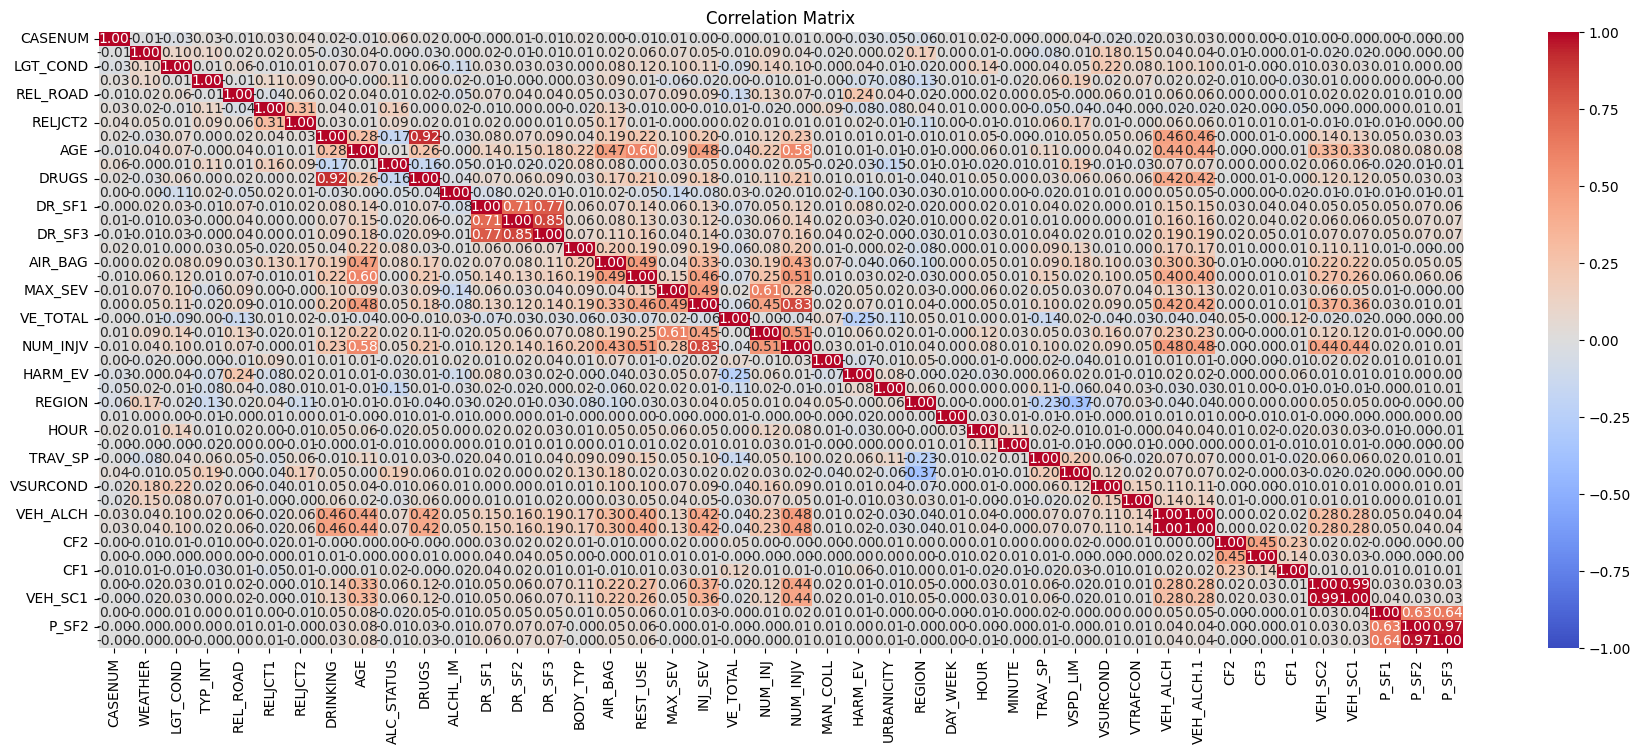

In [ ]:
# Load data
df = Traffic

# Compute correlation matrix for numeric columns
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(22, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation Matrix")
plt.show()

# Creates new column called 'OV_SPD' that represents whether a driver was overspeeding
df['OV_SPD'] = df.apply(
    lambda row: 1 if (row['TRAV_SP'] - row['VSPD_LIM'] >= 5) and row['TRAV_SP'] not in [997, 998, 999]
    else (0 if row['TRAV_SP'] not in [997, 998, 999] else np.nan),
    axis=1
)

In [ ]:
# Adjust MAX_SEV values and exclude rows where MAX_SEV is 9
df_filtered = df.copy()  # Create a copy of the DataFrame to avoid modifying the original

# Apply the transformation
df_filtered['MAX_SEV'] = df_filtered['MAX_SEV'].apply(
    lambda x: 1 if x in [1,2,5] else (2 if x in [3, 4] else (0 if x in [0,6,8] else None))
)

# Drop rows where MAX_SEV is None (these were originally 9)
df_filtered = df_filtered.dropna(subset=['MAX_SEV'])

# Convert MAX_SEV back to integer if necessary
df_filtered['MAX_SEV'] = df_filtered['MAX_SEV'].astype(int)

# The resulting DataFrame is now filtered and adjusted
df_filtered

# Classifications
# Max_SEV 0 = Low severity
# Max_SEV 1 = Mid Severity
# Max_SEV 2 = High severity

,CASENUM,WEATHER,LGT_COND,TYP_INT,REL_ROAD,RELJCT1,RELJCT2,DRINKING,AGE,ALC_STATUS,...,VEH_ALCH.1,CF2,CF3,CF1,VEH_SC2,VEH_SC1,P_SF1,P_SF2,P_SF3,OV_SPD
0,2.018000e+11,1,1,1,1,0,1,0,48,8,...,2,0,0,0,0,0,0,0,0,0.0
1,2.018000e+11,1,1,1,1,0,1,0,43,8,...,2,0,0,0,0,0,0,0,0,0.0
2,2.018000e+11,1,1,1,1,0,1,0,37,8,...,2,0,0,0,0,0,0,0,0,0.0
3,2.018000e+11,1,1,1,1,0,1,0,67,8,...,2,0,0,0,0,0,0,0,0,0.0
4,2.018000e+11,1,1,1,1,0,1,0,32,0,...,2,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115768,2.018010e+11,2,1,98,1,8,2,8,70,0,...,2,0,0,0,0,0,0,0,0,NaN
115769,2.018010e+11,98,3,1,1,8,8,0,27,8,...,2,0,0,0,0,0,0,0,0,NaN
115770,2.018010e+11,98,3,1,1,8,8,0,23,8,...,2,0,0,0,0,0,0,0,0,NaN
115771,2.018010e+11,1,3,2,1,0,2,0,66,8,...,2,0,0,0,0,0,0,0,0,1.0


In [ ]:
# Adjust MAX_SEV values and exclude rows where MAX_SEV is 9
df_filtered = df.copy()  # Create a copy of the DataFrame to avoid modifying the original

# Apply the transformation
df_filtered['MAX_SEV'] = df_filtered['MAX_SEV'].apply(
    lambda x: 1 if x in [1,2,5] else (2 if x in [3, 4] else (0 if x in [0,6,8] else None))
)

# Drop rows where MAX_SEV is None (these were originally 9)
df_filtered = df_filtered.dropna(subset=['MAX_SEV'])

# Convert MAX_SEV back to integer if necessary
df_filtered['MAX_SEV'] = df_filtered['MAX_SEV'].astype(int)

# The resulting DataFrame is now filtered and adjusted
df_filtered

# Max_SEV 0 = Low severity
# 1= Mid Severity
# 2 = High severity


,CASENUM,WEATHER,LGT_COND,TYP_INT,REL_ROAD,RELJCT1,RELJCT2,DRINKING,AGE,ALC_STATUS,...,VEH_ALCH.1,CF2,CF3,CF1,VEH_SC2,VEH_SC1,P_SF1,P_SF2,P_SF3,OV_SPD
0,2.018000e+11,1,1,1,1,0,1,0,48,8,...,2,0,0,0,0,0,0,0,0,0.0
1,2.018000e+11,1,1,1,1,0,1,0,43,8,...,2,0,0,0,0,0,0,0,0,0.0
2,2.018000e+11,1,1,1,1,0,1,0,37,8,...,2,0,0,0,0,0,0,0,0,0.0
3,2.018000e+11,1,1,1,1,0,1,0,67,8,...,2,0,0,0,0,0,0,0,0,0.0
4,2.018000e+11,1,1,1,1,0,1,0,32,0,...,2,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115768,2.018010e+11,2,1,98,1,8,2,8,70,0,...,2,0,0,0,0,0,0,0,0,NaN
115769,2.018010e+11,98,3,1,1,8,8,0,27,8,...,2,0,0,0,0,0,0,0,0,NaN
115770,2.018010e+11,98,3,1,1,8,8,0,23,8,...,2,0,0,0,0,0,0,0,0,NaN
115771,2.018010e+11,1,3,2,1,0,2,0,66,8,...,2,0,0,0,0,0,0,0,0,1.0


In [ ]:
# List of columns to retain in df_filtered
columns_to_keep = [
    'WEATHER', 'LGT_COND', 'TYP_INT', 'AGE', 'DR_SF1', 'AIR_BAG', 'REST_USE',
    'MAX_SEV', 'VE_TOTAL', 'NUM_INJ', 'REGION', 'DAY_WEEK', 'HOUR',
    'TRAV_SP', 'VSPD_LIM', 'OV_SPD', 'VSURCOND', 'VEH_ALCH'
]

# Filter df_filtered to retain only the specified columns
df_filtered2 = df_filtered[columns_to_keep]

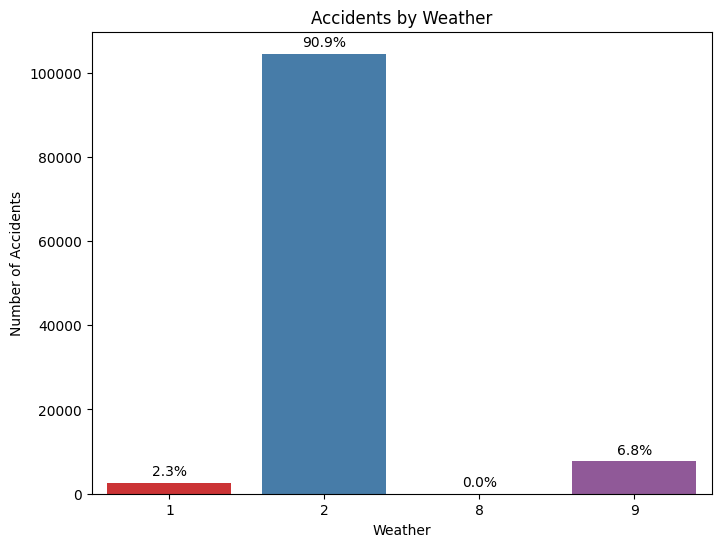

In [ ]:
total = len(df_filtered2)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='VEH_ALCH', data=df_filtered2, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Accidents by Weather")
plt.xlabel("Weather")
plt.ylabel("Number of Accidents")
plt.show()

#1 Alcohol Involved
#2 No Alcohol Involved
#8 No Driver Present/Unknown if Driver Present
#9 Unknown

1 Alcohol Involved
2 No Alcohol Involved
8 No Driver Present/Unknown if Driver Present
9 Unknown

Weather Plot

In [ ]:
total = len(df)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='VEH_ALCH', data=df, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Accidents by Drunk Driver")
plt.xlabel("Drunk Driver")
plt.ylabel("Number of Accidents")
plt.show()

#1 Alcohol Involved
#2 No Alcohol Involved
#8 No Driver Present/Unknown if Driver Present
#9 Unknown

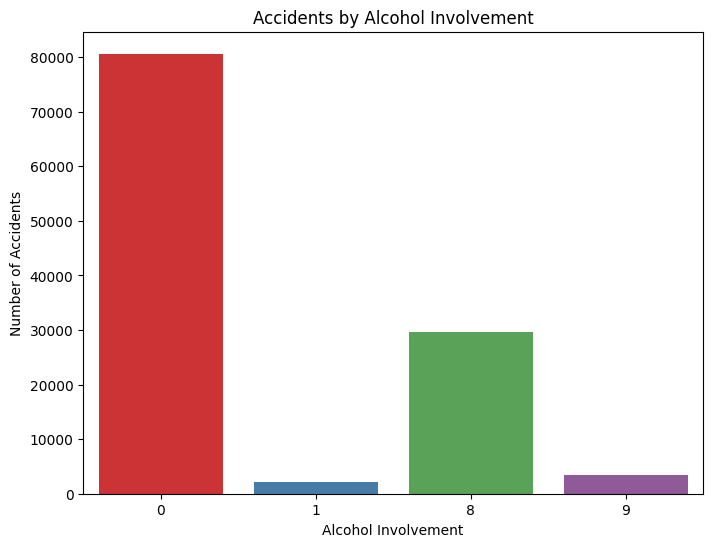

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='DRINKING', data=df, palette='Set1')
plt.title("Accidents by Alcohol Involvement")
plt.xlabel("Alcohol Involvement")
plt.ylabel("Number of Accidents")
plt.show()

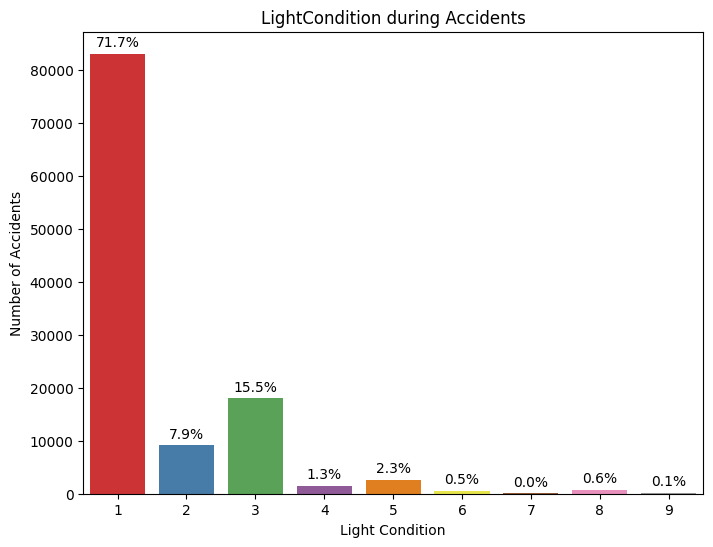

In [ ]:
total = len(df)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='LGT_COND', data=df, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("LightCondition during Accidents")
plt.xlabel("Light Condition")
plt.ylabel("Number of Accidents")
plt.show()

#1 Daylight
#2 Dark – Not Lighted
#3 Dark – Lighted
#4 Dawn
#5 Dusk
# 6Dark – Unknown Lighting
#7 Other
#8 Not Reported
#9 Reported as Unknown



1 Daylight.
2 Dark – Not Lighted.
3 Dark – Lighted.
4 Dawn.
5 Dusk.
6 Dark – Unknown Lighting.
7 Other.
8 Not Reported.
9 Reported as Unknown.


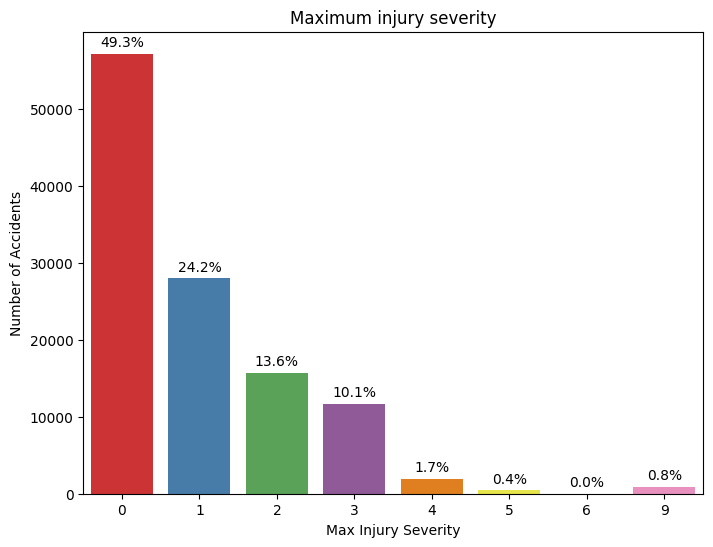

In [ ]:
total = len(df)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='MAX_SEV', data=df, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Maximum injury severity")
plt.xlabel("Max Injury Severity")
plt.ylabel("Number of Accidents")
plt.show()

#0 No Apparent Injury
#1 Possible Injury
#2 Suspected Minor Injury
#3 Suspected Serious Injury
#4 Fatal
#5 Injured, Severity Unknown
#6 Died Prior to Crash
#8 No Person Involved in Crash
#9 Unknown/Not Reported"

In [ ]:
# Splitting the data into two DataFrames based on the MAX_SEV value

df_ls = df[df['MAX_SEV'].isin([0,6,8])]
df_ms = df[df['MAX_SEV'].isin([1,2,5])]
df_hs = df[df['MAX_SEV'].isin([3,4])]

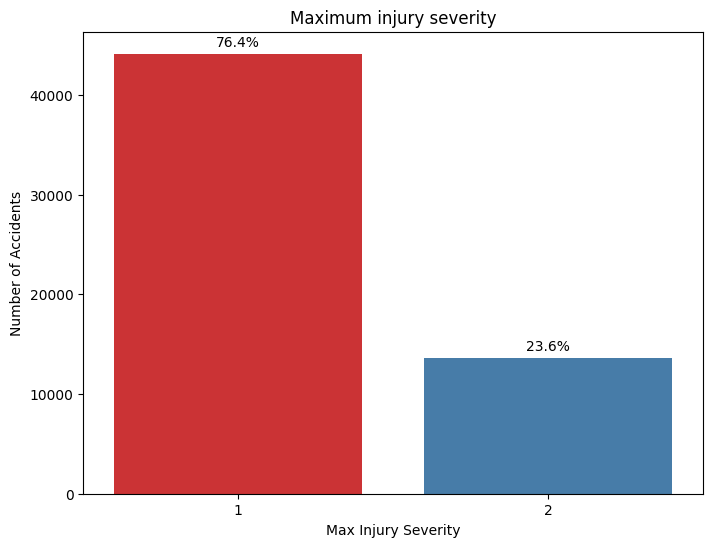

In [ ]:
total = len(df_ms)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='MAX_SEV', data=df_ms, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage based on df_s
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Maximum injury severity")
plt.xlabel("Max Injury Severity")
plt.ylabel("Number of Accidents")
plt.show()

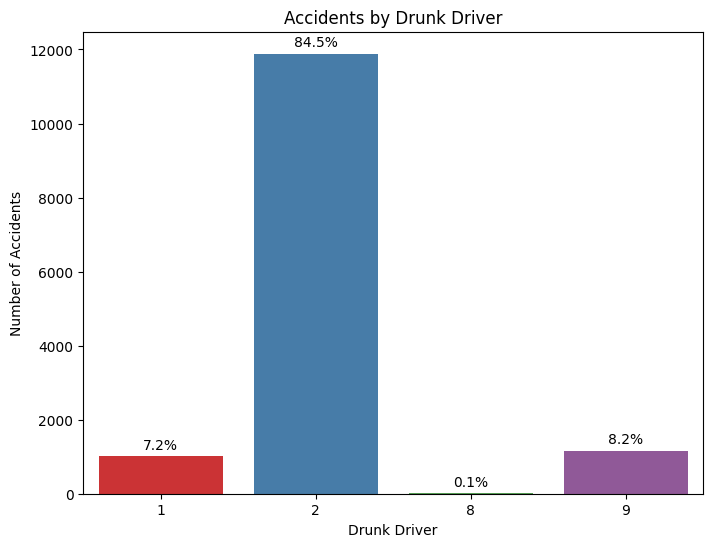

In [ ]:
total = len(df_hs)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='VEH_ALCH', data=df_hs, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Accidents by Drunk Driver")
plt.xlabel("Drunk Driver")
plt.ylabel("Number of Accidents")
plt.show()

#1 Alcohol Involved
#2 No Alcohol Involved
#8 No Driver Present/Unknown if Driver Present
#9 Unknown

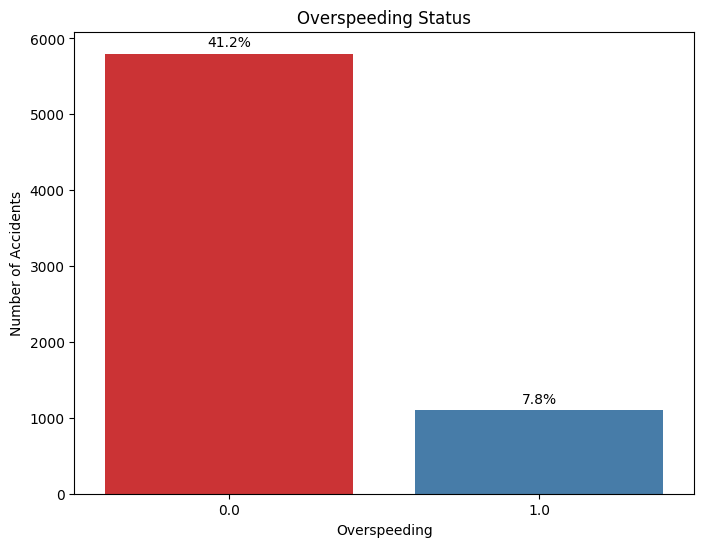

In [ ]:
total = len(df_hs)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='OV_SPD', data=df_hs, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Overspeeding Status")
plt.xlabel("Overspeeding")
plt.ylabel("Number of Accidents")
plt.show()

#1 Alcohol Involved
#2 No Alcohol Involved
#8 No Driver Present/Unknown if Driver Present
#9 Unknown

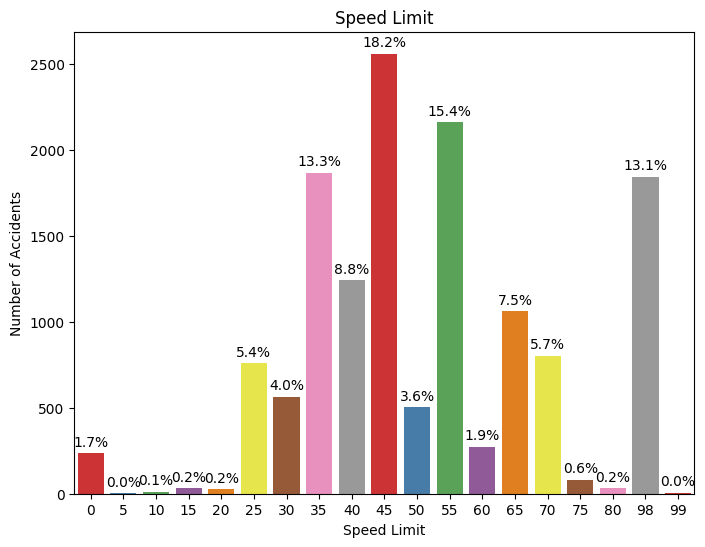

In [ ]:
total = len(df_hs)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='VSPD_LIM', data=df_hs, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Speed Limit")
plt.xlabel("Speed Limit")
plt.ylabel("Number of Accidents")
plt.show()

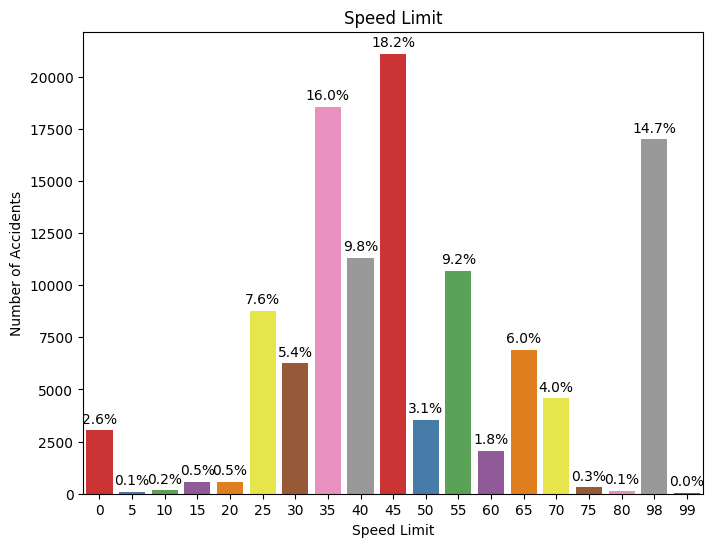

In [ ]:
total = len(df)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='VSPD_LIM', data=df, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Speed Limit")
plt.xlabel("Speed Limit")
plt.ylabel("Number of Accidents")
plt.show()

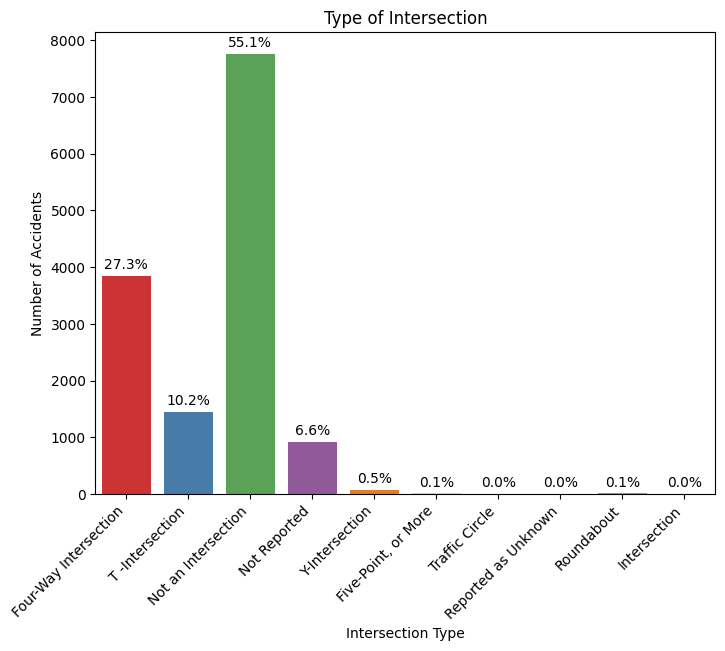

In [ ]:

# Mapping TYP_INT values to actual descriptions
intersection_type_mapping = {
    1: "Not an Intersection",
    2: "Four-Way Intersection",
    3: "T -Intersection",
    4: "Y-Intersection",
    5: "Traffic Circle",
    6: "Roundabout",
    7: "Five-Point, or More",
    10: "Intersection",
    98: "Not Reported",
    99: "Reported as Unknown"
}

# Apply the mapping to df_hs
df_hs['TYP_INT'] = df_hs['TYP_INT'].map(intersection_type_mapping)

total = len(df_hs)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='TYP_INT', data=df_hs, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Type of Intersection")
plt.xlabel("Intersection Type")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45, ha="right")  # Rotate labels for readability
plt.show()

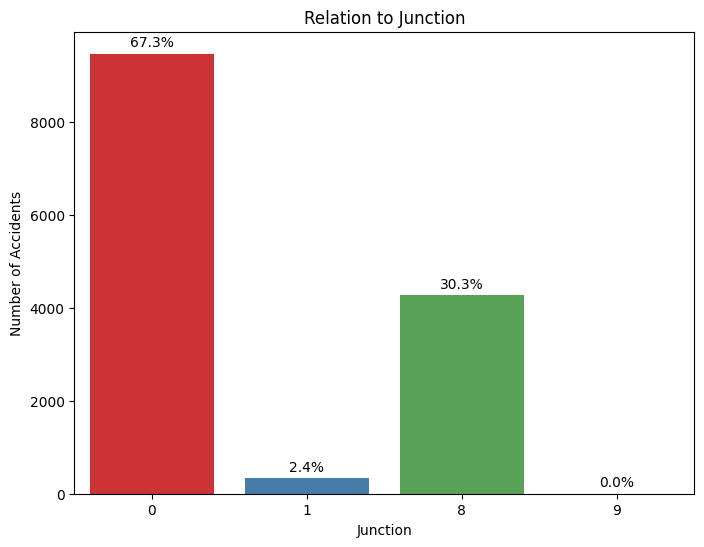

In [ ]:
total = len(df_hs)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='RELJCT1', data=df_hs, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Relation to Junction")
plt.xlabel("Junction")
plt.ylabel("Number of Accidents")
plt.show()

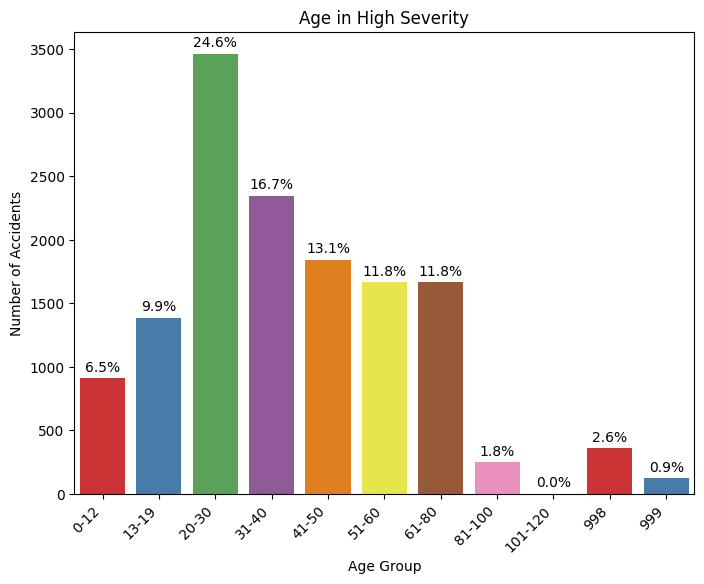

In [ ]:
# Define age bins and corresponding labels
age_bins = [0, 12, 19, 30, 40, 50, 60, 80, 100, 120, 998, 999]
age_labels = ["0-12", "13-19", "20-30", "31-40", "41-50", "51-60", "61-80", "81-100", "101-120", "998", "999"]

# Bin the AGE column into the defined ranges in df_hs
df_hs['AGE_GROUP'] = pd.cut(df_hs['AGE'], bins=age_bins, labels=age_labels, right=True)

# Plot with the new age group labels
total = len(df_hs)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='AGE_GROUP', data=df_hs, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Age in High Severity")
plt.xlabel("Age Group")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45, ha="right")  # Rotate labels for readability
plt.show()

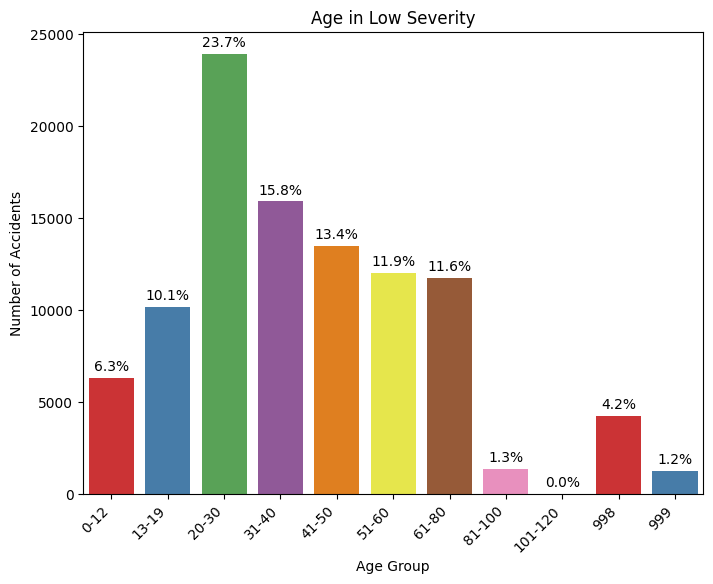

In [ ]:
# Define age bins and corresponding labels
age_bins = [0, 12, 19, 30, 40, 50, 60, 80, 100, 120, 998, 999]
age_labels = ["0-12", "13-19", "20-30", "31-40", "41-50", "51-60", "61-80", "81-100", "101-120", "998", "999"]

# Bin the AGE column into the defined ranges in df_hs
df_ls['AGE_GROUP'] = pd.cut(df_ls['AGE'], bins=age_bins, labels=age_labels, right=True)

# Plot with the new age group labels
total = len(df_ls)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='AGE_GROUP', data=df_ls, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Age in Low Severity")
plt.xlabel("Age Group")
plt.ylabel("Number of Accidents")
plt.xticks(rotation=45, ha="right")  # Rotate labels for readability
plt.show()

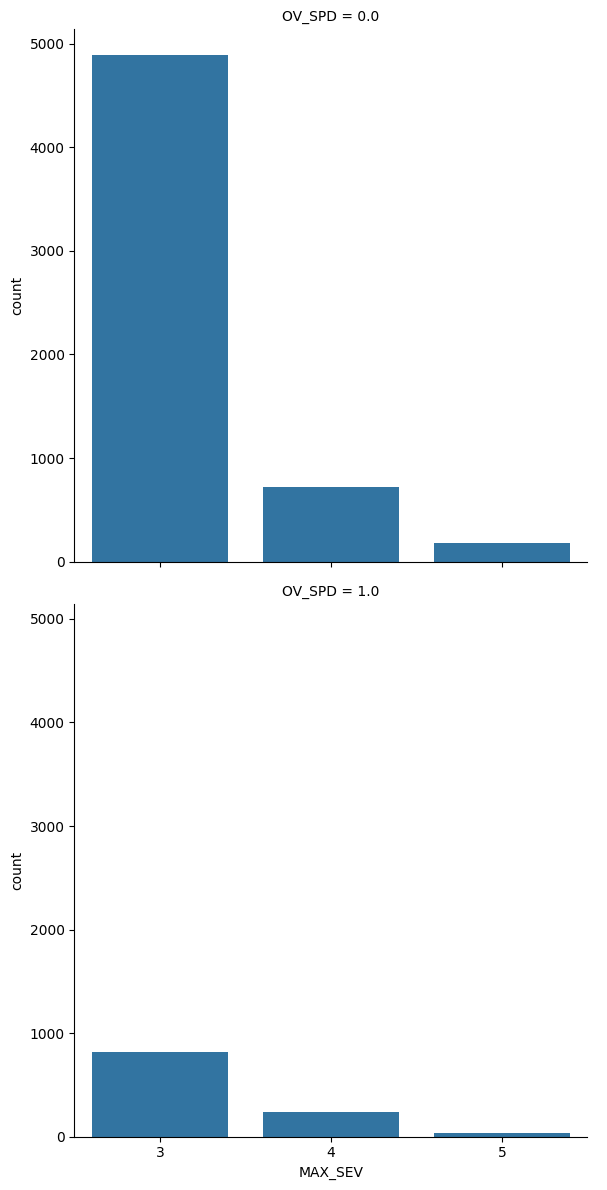

In [ ]:
sns.catplot(x='MAX_SEV', row='OV_SPD',
            kind='count', data=df_hs,
            height=6, aspect=1)  # You can adjust the values of height and aspect
plt.show()

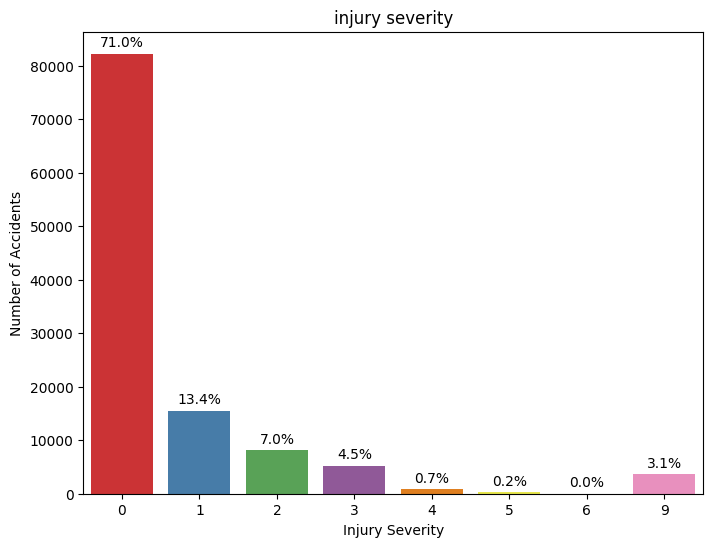

In [ ]:
total = len(df)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='INJ_SEV', data=df, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("injury severity")
plt.xlabel("Injury Severity")
plt.ylabel("Number of Accidents")
plt.show()

#0 No Apparent Injury (O)
#1 Possible Injury (C)
#2 Suspected Minor Injury (B)
#3 Suspected Serious Injury (A)
#4 Fatal Injury (K)
#5 Injured, Severity Unknown (U)
#6 Died Prior to Crash
#9 Unknown/Not Reported"

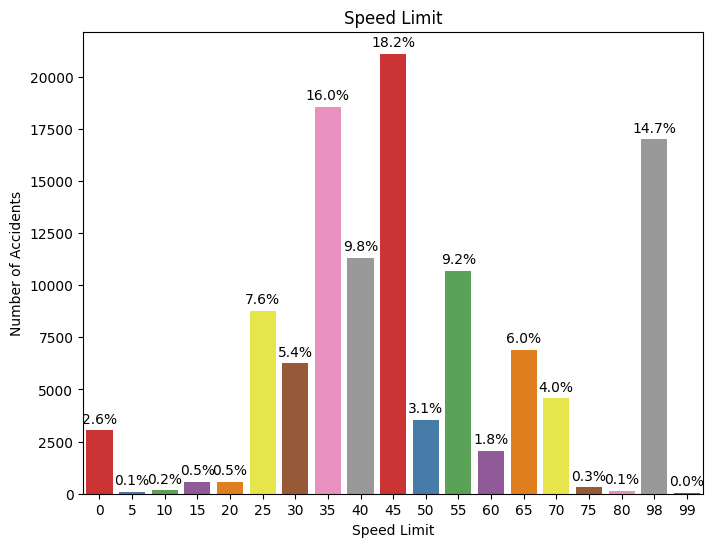

In [ ]:
total = len(df)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='VSPD_LIM', data=df, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Speed Limit")
plt.xlabel("Speed Limit")
plt.ylabel("Number of Accidents")
plt.show()

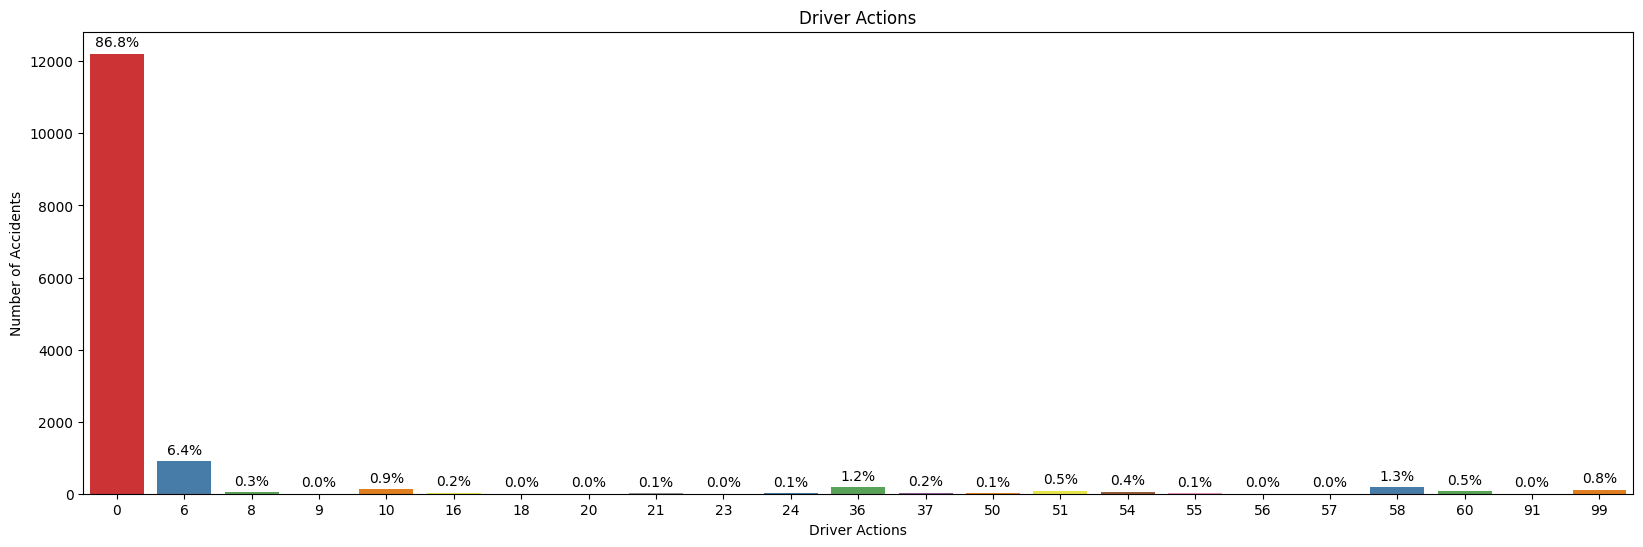

In [ ]:
total = len(df_hs)
plt.figure(figsize=(20, 6))
ax = sns.countplot(x='DR_SF1', data=df_hs, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Driver Actions")
plt.xlabel("Driver Actions")
plt.ylabel("Number of Accidents")
plt.show()

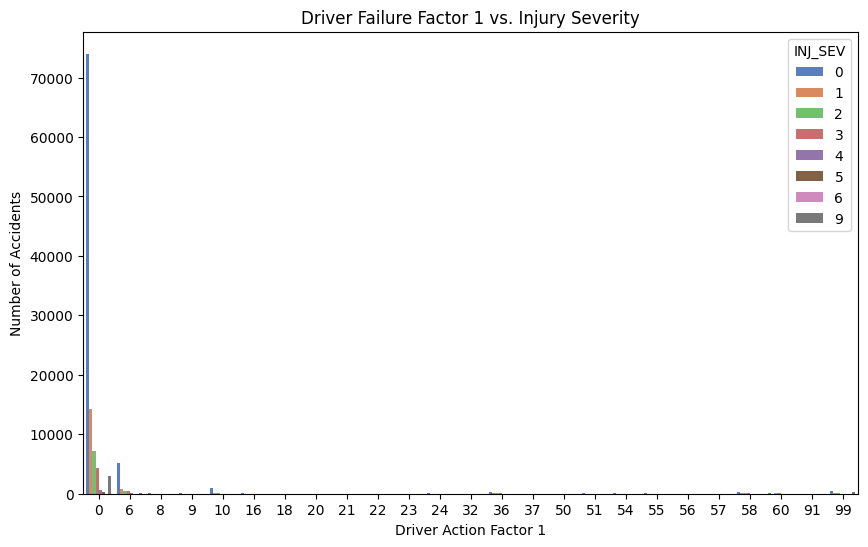

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='DR_SF1', hue='INJ_SEV', data=df, palette='muted')
plt.title("Driver Failure Factor 1 vs. Injury Severity")
plt.xlabel("Driver Action Factor 1")
plt.ylabel("Number of Accidents")
plt.show()

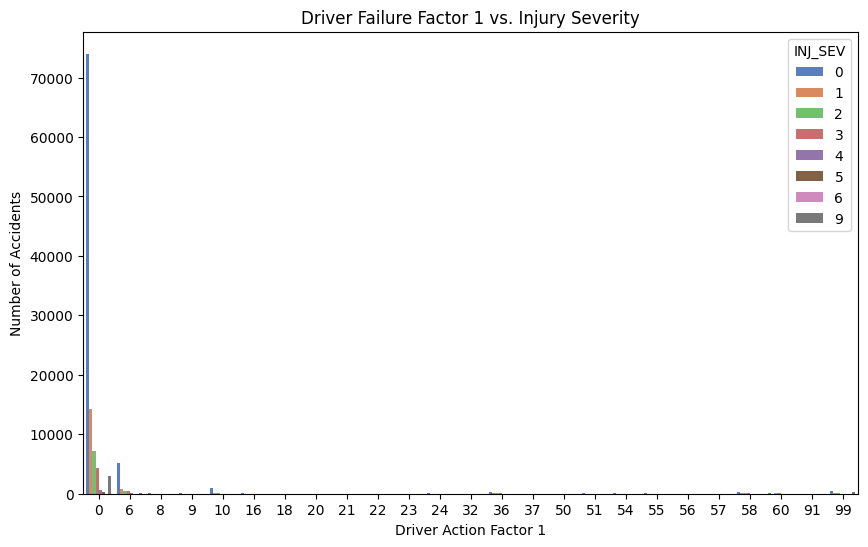

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='DR_SF1', hue='INJ_SEV', data=df, palette='muted')
plt.title("Driver Failure Factor 1 vs. Injury Severity")
plt.xlabel("Driver Action Factor 1")
plt.ylabel("Number of Accidents")
plt.show()

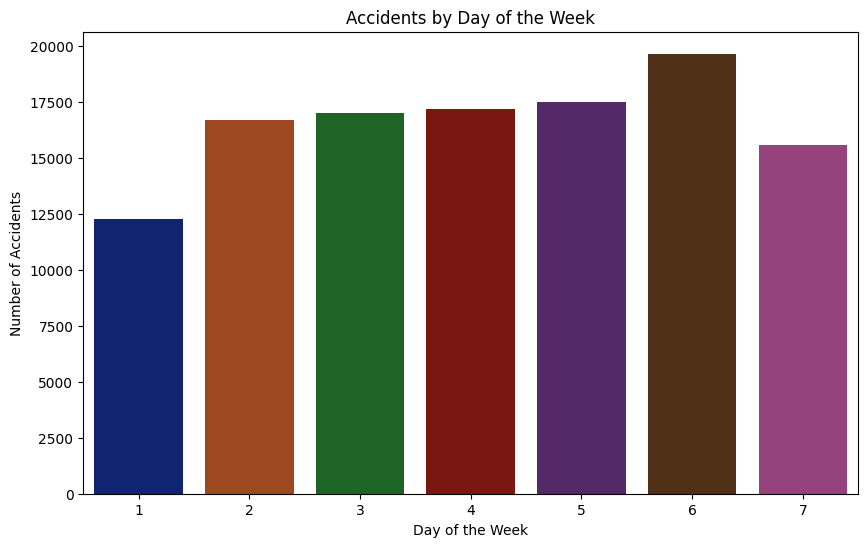

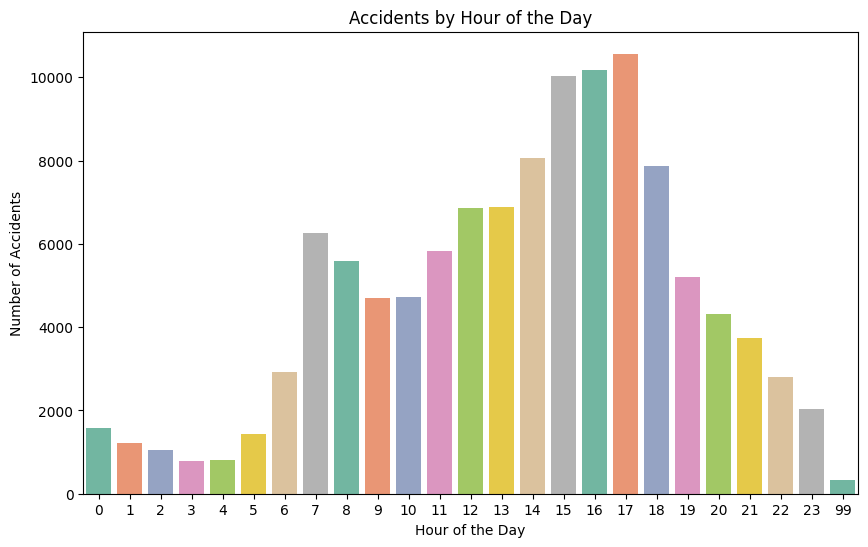

In [ ]:
# Accident count by day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='DAY_WEEK', data=df, palette='dark')
plt.title("Accidents by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Accidents")
plt.show()

# Accident count by hour of the day
plt.figure(figsize=(10, 6))
sns.countplot(x='HOUR', data=df, palette='Set2')
plt.title("Accidents by Hour of the Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Accidents")
plt.show()

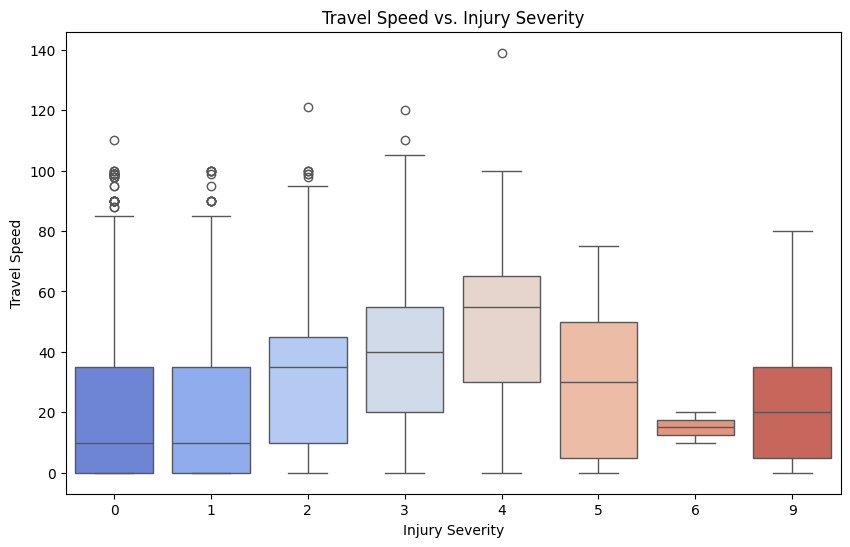

In [ ]:
#We filter out the rows with TRAV_SP values 997,998,999
df_filtered = df[~df['TRAV_SP'].isin([997, 998, 999])]
# Boxplot for travel speed vs. injury severity
plt.figure(figsize=(10, 6))
sns.boxplot(x='INJ_SEV', y='TRAV_SP', data=df_filtered, palette='coolwarm')
plt.title("Travel Speed vs. Injury Severity")
plt.xlabel("Injury Severity")
plt.ylabel("Travel Speed")
plt.show()

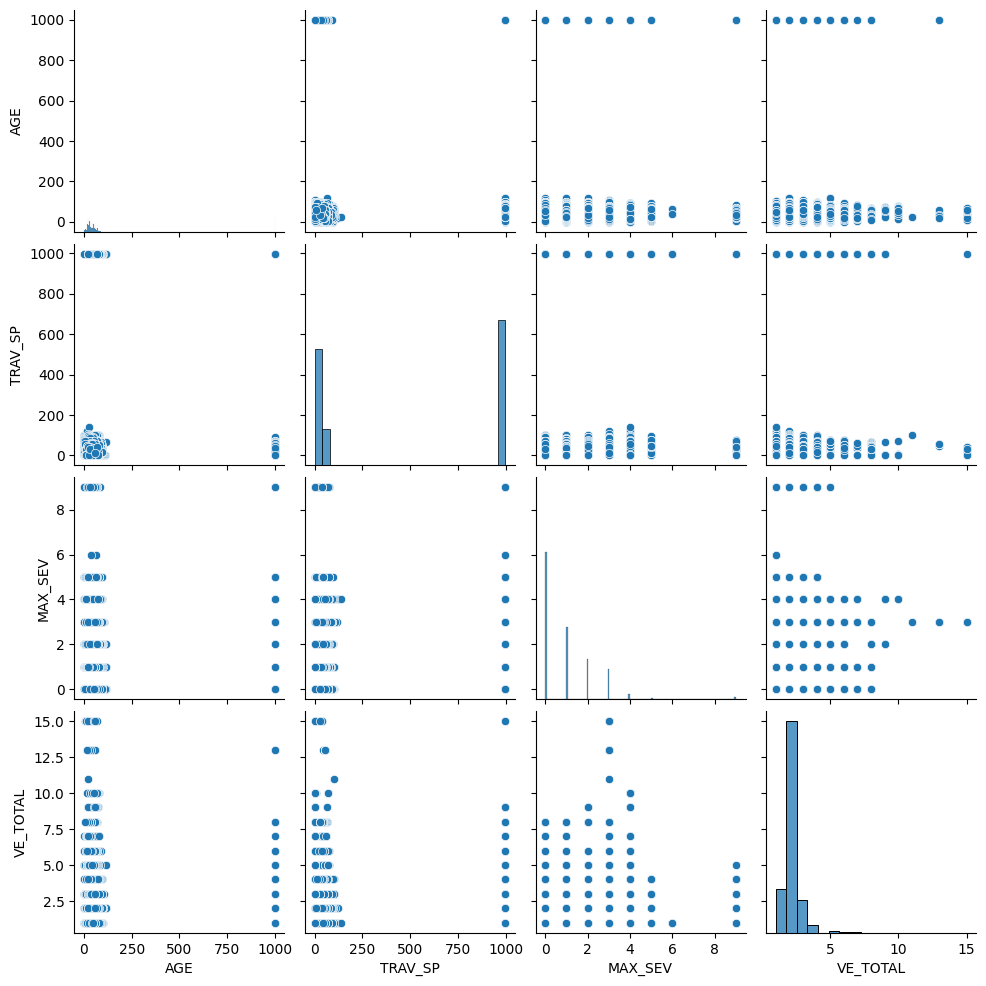

In [ ]:
# Pairplot for some selected numerical features
sns.pairplot(df[['AGE', 'TRAV_SP', 'MAX_SEV', 'VE_TOTAL']])
plt.show()

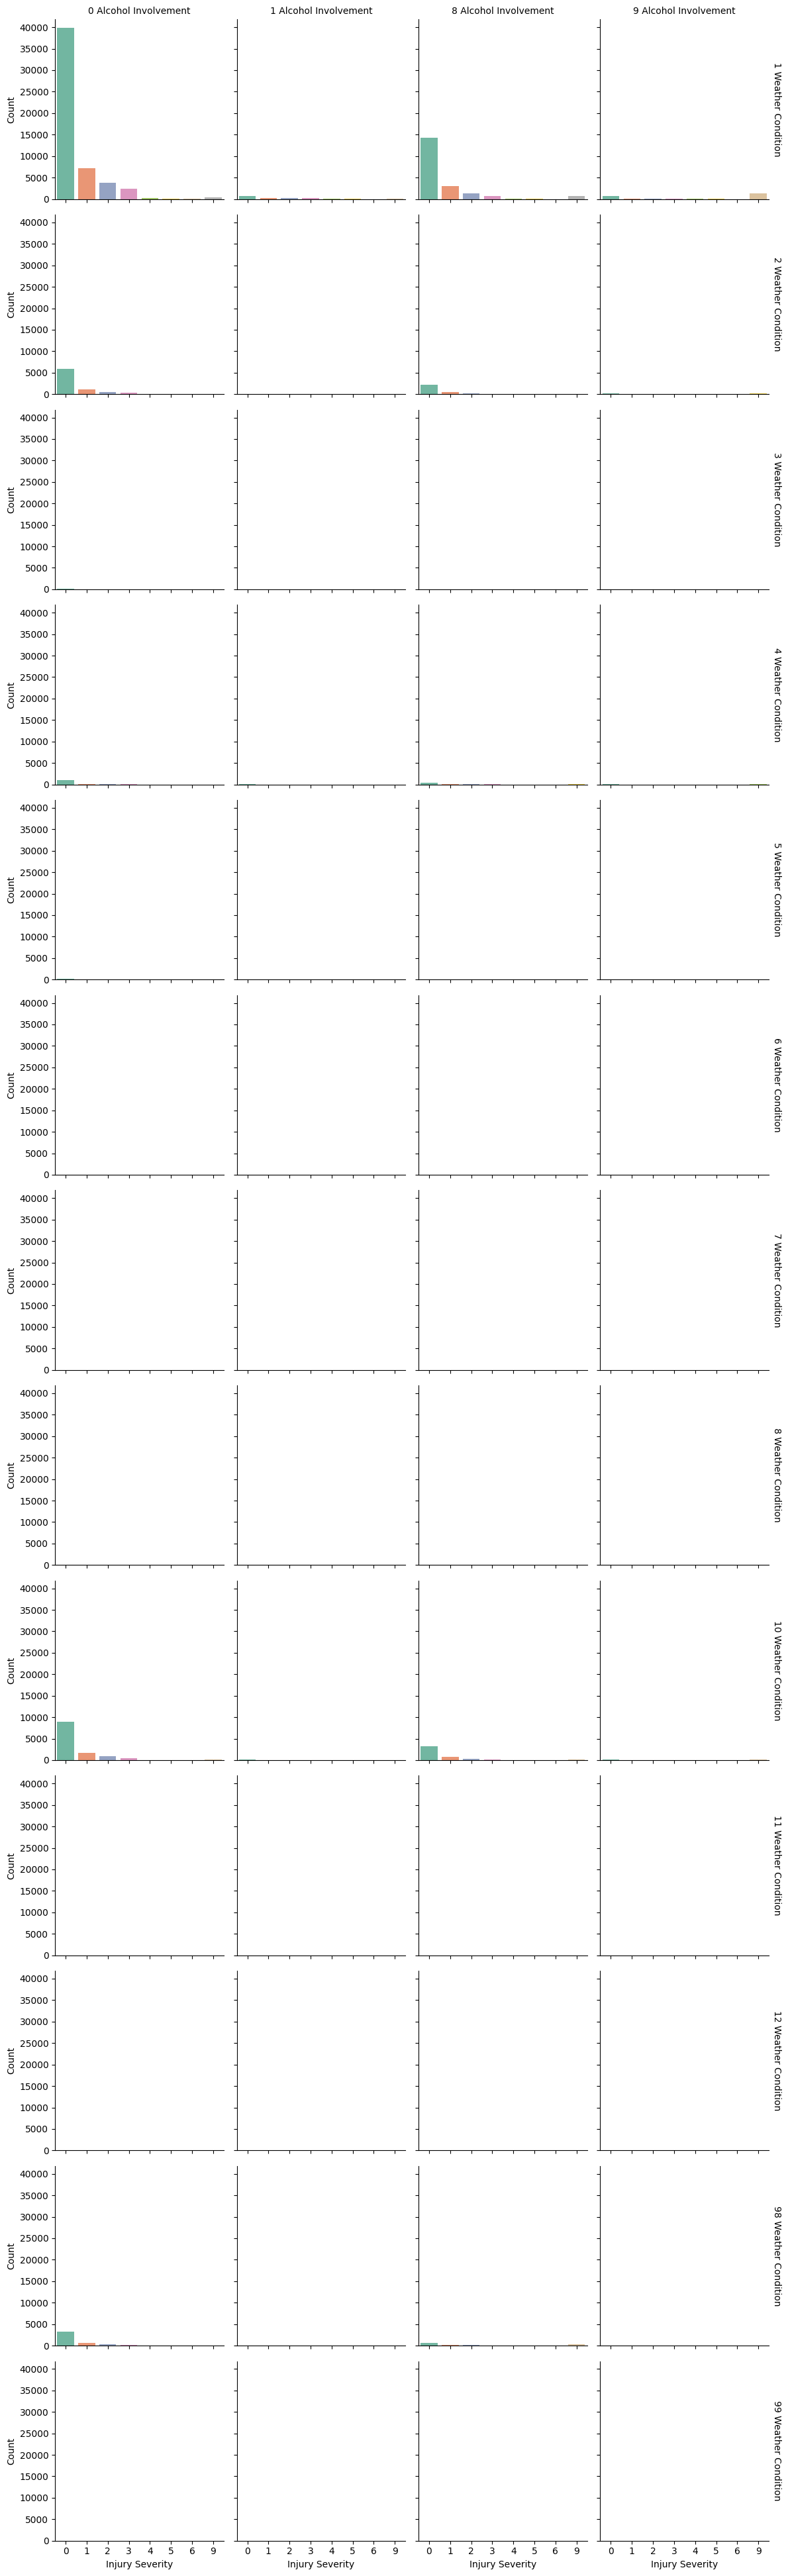

In [ ]:
# FacetGrid for alcohol involvement and weather condition by injury severity
g = sns.FacetGrid(df, col='DRINKING', row='WEATHER', margin_titles=True)
g.map(sns.countplot, 'INJ_SEV', palette='Set2')
g.set_axis_labels('Injury Severity', 'Count')
g.set_titles(col_template="{col_name} Alcohol Involvement", row_template="{row_name} Weather Condition")
plt.show()

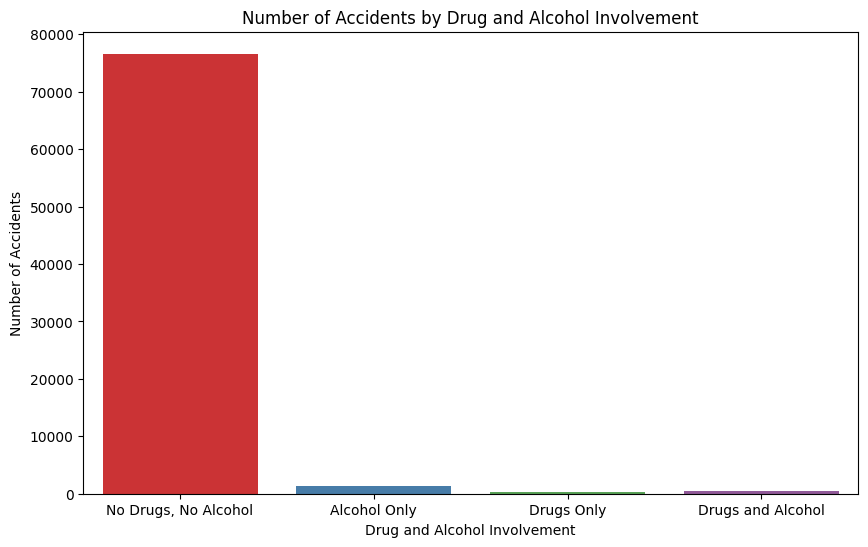

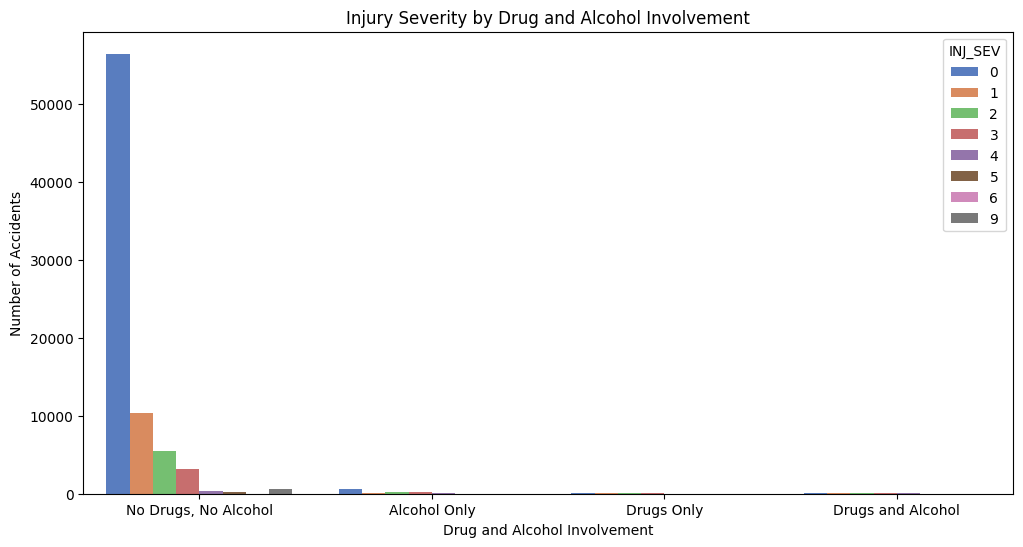

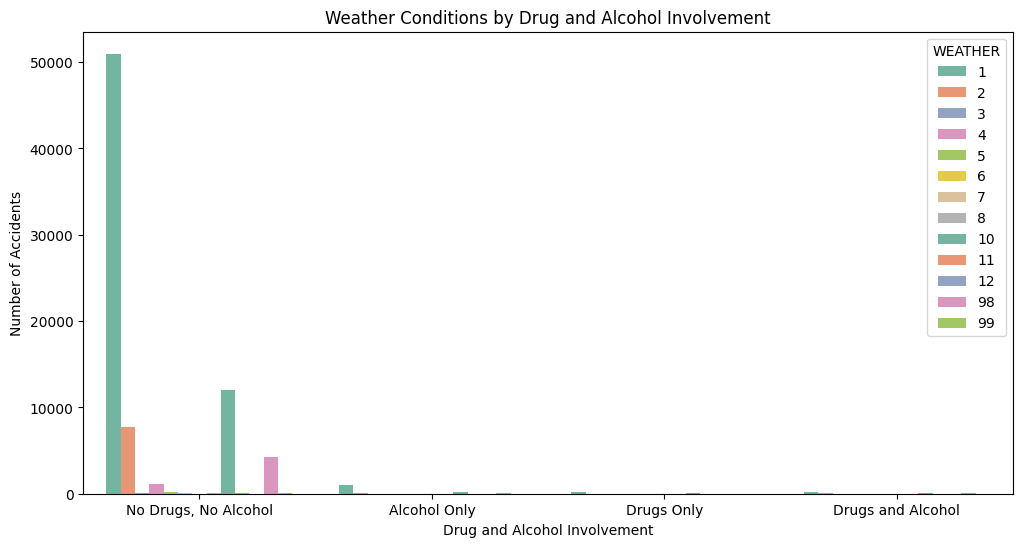

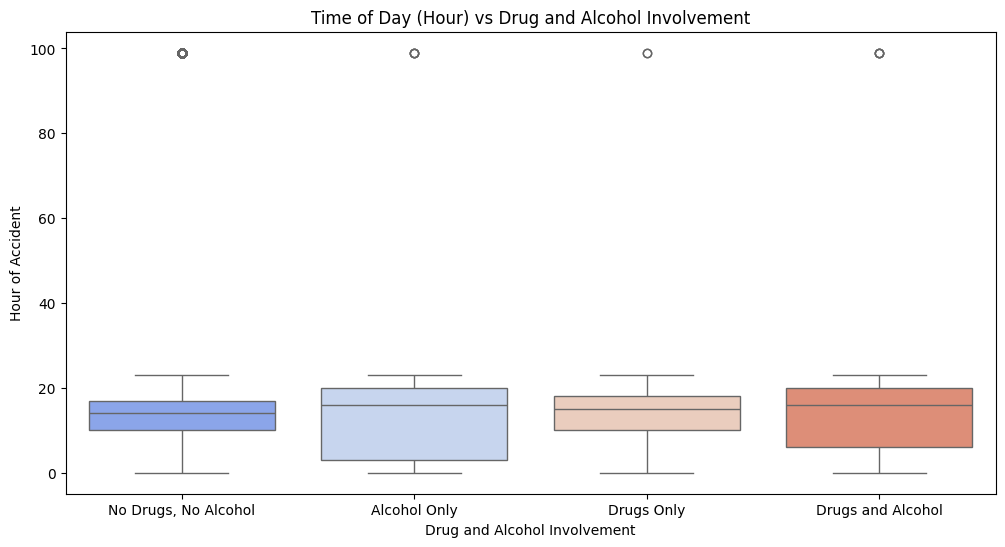

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('filtered_accident_data_1.csv')  # Replace with your actual file path

# Step 1: Create a new column 'Drug_Alcohol_Status' based on DRUGS and DRINKING columns
def categorize_drugs_alcohol(row):
    if row['DRUGS'] == 0 and row['DRINKING'] == 0:
        return 'No Drugs, No Alcohol'
    elif row['DRUGS'] == 1 and row['DRINKING'] == 0:
        return 'Drugs Only'
    elif row['DRUGS'] == 0 and row['DRINKING'] == 1:
        return 'Alcohol Only'
    elif row['DRUGS'] == 1 and row['DRINKING'] == 1:
        return 'Drugs and Alcohol'

# Apply the function to create the new column
df['Drug_Alcohol_Status'] = df.apply(categorize_drugs_alcohol, axis=1)

# Step 2: Create visualizations based on the 'Drug_Alcohol_Status' categories

# 2.1 Count Plot for the number of accidents in each category
plt.figure(figsize=(10, 6))
sns.countplot(x='Drug_Alcohol_Status', data=df, palette='Set1')
plt.title("Number of Accidents by Drug and Alcohol Involvement")
plt.xlabel("Drug and Alcohol Involvement")
plt.ylabel("Number of Accidents")
plt.show()

# 2.2 Compare Injury Severity based on Drug and Alcohol Involvement
plt.figure(figsize=(12, 6))
sns.countplot(x='Drug_Alcohol_Status', hue='INJ_SEV', data=df, palette='muted')
plt.title("Injury Severity by Drug and Alcohol Involvement")
plt.xlabel("Drug and Alcohol Involvement")
plt.ylabel("Number of Accidents")
plt.show()

# 2.3 Compare Weather Conditions based on Drug and Alcohol Involvement
plt.figure(figsize=(12, 6))
sns.countplot(x='Drug_Alcohol_Status', hue='WEATHER', data=df, palette='Set2')
plt.title("Weather Conditions by Drug and Alcohol Involvement")
plt.xlabel("Drug and Alcohol Involvement")
plt.ylabel("Number of Accidents")
plt.show()

# 2.4 Compare Time of Day (HOUR) based on Drug and Alcohol Involvement
plt.figure(figsize=(12, 6))
sns.boxplot(x='Drug_Alcohol_Status', y='HOUR', data=df, palette='coolwarm')
plt.title("Time of Day (Hour) vs Drug and Alcohol Involvement")
plt.xlabel("Drug and Alcohol Involvement")
plt.ylabel("Hour of Accident")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Split df_filtered2 into 80% training and 20% testing
train_data, test_data = train_test_split(df_filtered2, test_size=0.2, random_state=42, stratify=df_filtered2['MAX_SEV'])


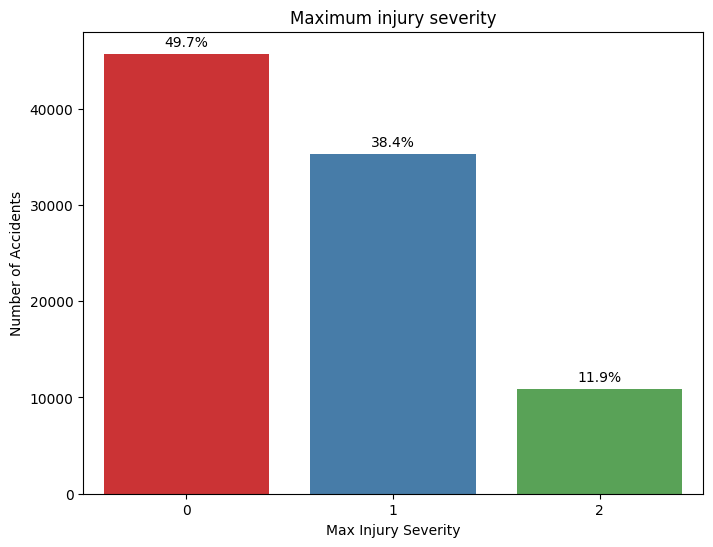

In [ ]:
#Check if data is balanced or unbalanced

total = len(train_data)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='MAX_SEV', data=train_data, palette='Set1')

# Add percentages as labels
for p in ax.patches:
    percentage = f"{(p.get_height() / total) * 100:.1f}%"  # Calculate percentage
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 8),
                textcoords='offset points')

# Customize plot appearance
plt.title("Maximum injury severity")
plt.xlabel("Max Injury Severity")
plt.ylabel("Number of Accidents")
plt.show()

Data is unbalanced so we use oversampling/undersampling to balance balance data when training the Models

# DECISION TREE

Accuracy: 43.56%
Precision (Weighted): 44.88%
F1 Score (Weighted): 43.21%

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.54      0.47     22749
           1       0.42      0.44      0.43     22879
           2       0.52      0.33      0.40     22920

    accuracy                           0.44     68548
   macro avg       0.45      0.44      0.43     68548
weighted avg       0.45      0.44      0.43     68548



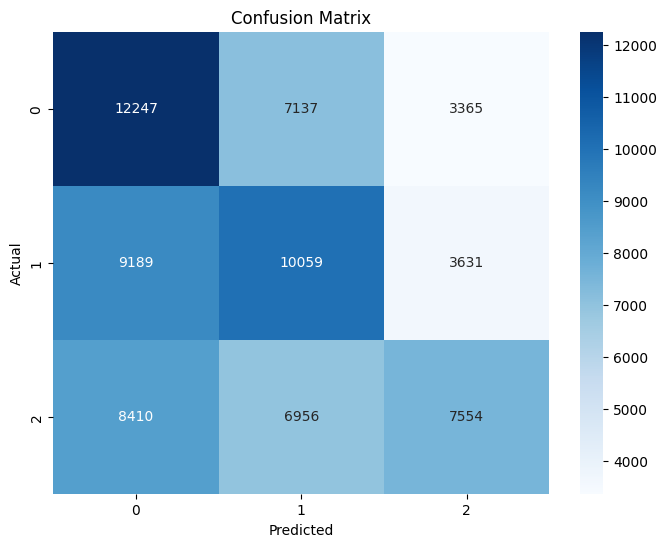

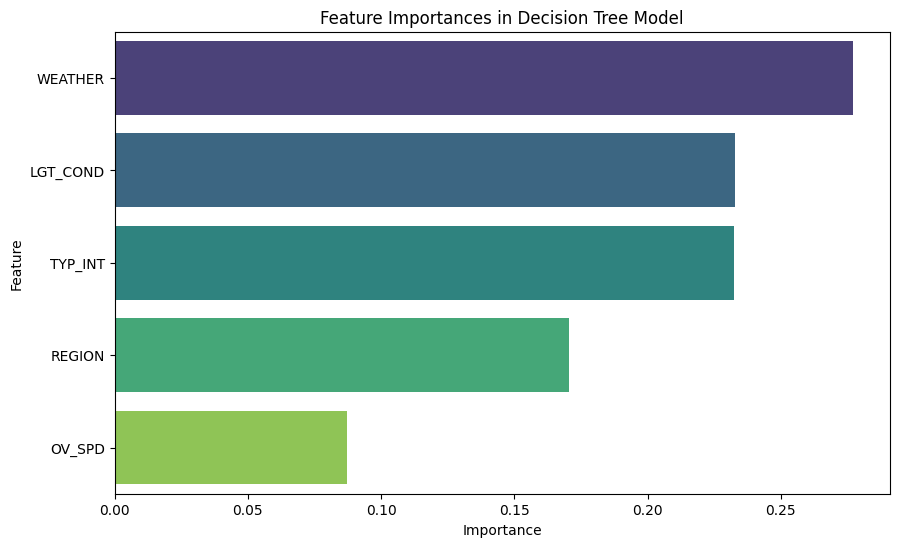

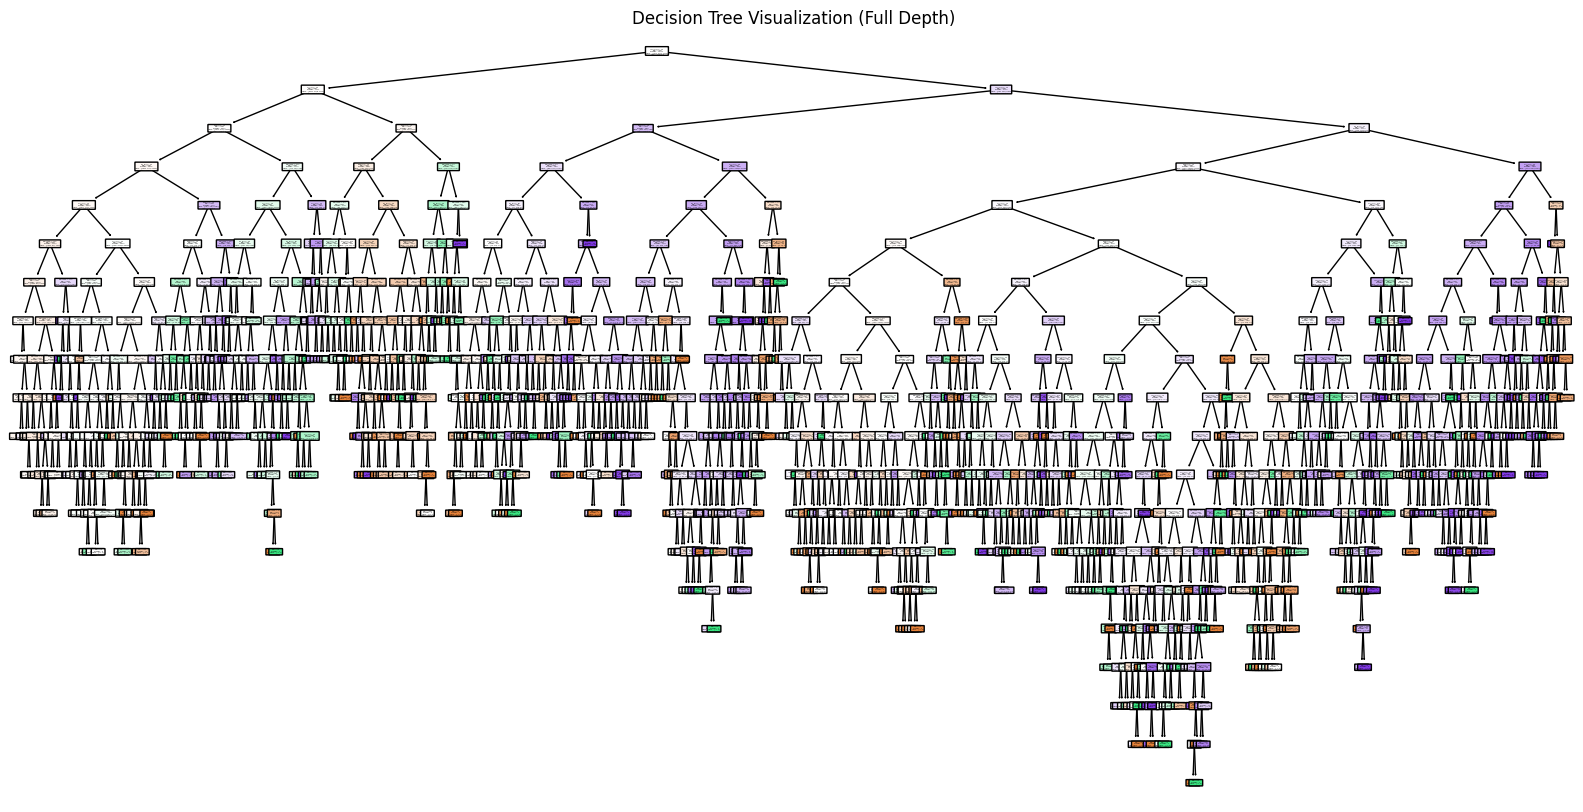


Feature Importances:
    Feature  Importance
0   WEATHER    0.276926
1  LGT_COND    0.232858
2   TYP_INT    0.232482
3    REGION    0.170450
4    OV_SPD    0.087285

Conclusion: There is evidence to reject the null hypothesis (H0).
Environmental factors significantly impact accident severity.


In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, f1_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# Step 2: Load the dataset
df = df_filtered2  # Assuming df_filtered2 is pre-loaded with necessary data

# Step 3: Separate the classes based on MAX_SEV values
df_class_0 = df[df['MAX_SEV'] == 0]
df_class_1 = df[df['MAX_SEV'] == 1]
df_class_2 = df[df['MAX_SEV'] == 2]

# Step 4: Find the maximum sample size for oversampling
max_size = max(len(df_class_0), len(df_class_1), len(df_class_2))

# Oversampling: Up-sample minority classes to match the maximum class size
df_class_0_over = resample(df_class_0, replace=True, n_samples=max_size, random_state=42)
df_class_1_over = resample(df_class_1, replace=True, n_samples=max_size, random_state=42)
df_class_2_over = resample(df_class_2, replace=True, n_samples=max_size, random_state=42)

# Concatenate over-sampled DataFrames to create a balanced dataset
df_balanced = pd.concat([df_class_0_over, df_class_1_over, df_class_2_over])

# Step 5: Select features for the hypothesis
features = ['WEATHER', 'LGT_COND', 'TYP_INT','REGION','OV_SPD']
target = 'MAX_SEV'

# Step 6: Prepare the data for training
X = df_balanced[features]
y = df_balanced[target]

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Step 8: Train the Decision Tree model with full depth
dt_model = DecisionTreeClassifier(random_state=42)  # No depth limitation
dt_model.fit(X_train, y_train)

# Step 9: Make predictions
y_pred = dt_model.predict(X_test)

# Step 10: Evaluate the model using accuracy, precision, recall, F1 score, and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Weighted to handle multiple classes
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision * 100:.2f}%")
print(f"F1 Score (Weighted): {f1 * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 11: Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 12: Feature importance analysis
feature_importances = dt_model.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances in Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 13: Visualize the Decision Tree using plot_tree()
plt.figure(figsize=(20, 10))  # Set the figure size large enough to accommodate the entire tree
plot_tree(dt_model, feature_names=features, class_names=['Severity 0', 'Severity 1', 'Severity 2'], filled=True, rounded=True)
plt.title('Decision Tree Visualization (Full Depth)')
plt.savefig('decision_tree_visualization_full_depth.png', dpi=300, bbox_inches='tight')  # Save the visualization as a PNG file
plt.show()

# Step 14: Graphviz Visualization (optional)
# Export the decision tree to a dot file and visualize using Graphviz
dot_data = export_graphviz(dt_model, out_file=None,
                           feature_names=features,
                           class_names=['Severity 0', 'Severity 1', 'Severity 2'],
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree_visualization_full_depth")  # Saves as a PDF
graph.view()  # View the PDF output

# Step 15: Interpretation of Results
# Based on the accuracy, precision, and F1 score, determine if environmental factors significantly impact accident severity
print("\nFeature Importances:")
print(importance_df)

if importance_df['Importance'].iloc[0] > 0.1:  # Assuming a threshold of 0.1 as significant importance
    print("\nConclusion: There is evidence to reject the null hypothesis (H0).")
    print("Environmental factors significantly impact accident severity.")
else:
    print("\nConclusion: We fail to reject the null hypothesis (H0).")
    print("Environmental factors may not significantly impact accident severity.")


Accuracy: 38.78%
Precision (Weighted): 39.62%
F1 Score (Weighted): 36.05%

Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.64      0.47     22749
           1       0.41      0.15      0.22     22879
           2       0.41      0.37      0.39     22920

    accuracy                           0.39     68548
   macro avg       0.40      0.39      0.36     68548
weighted avg       0.40      0.39      0.36     68548



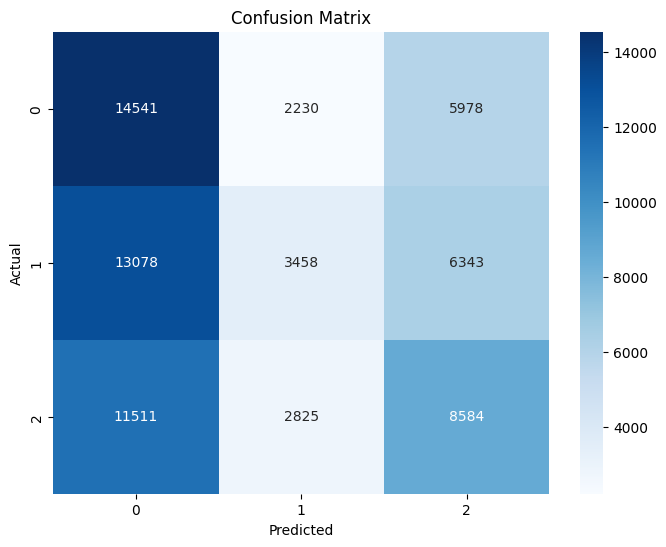

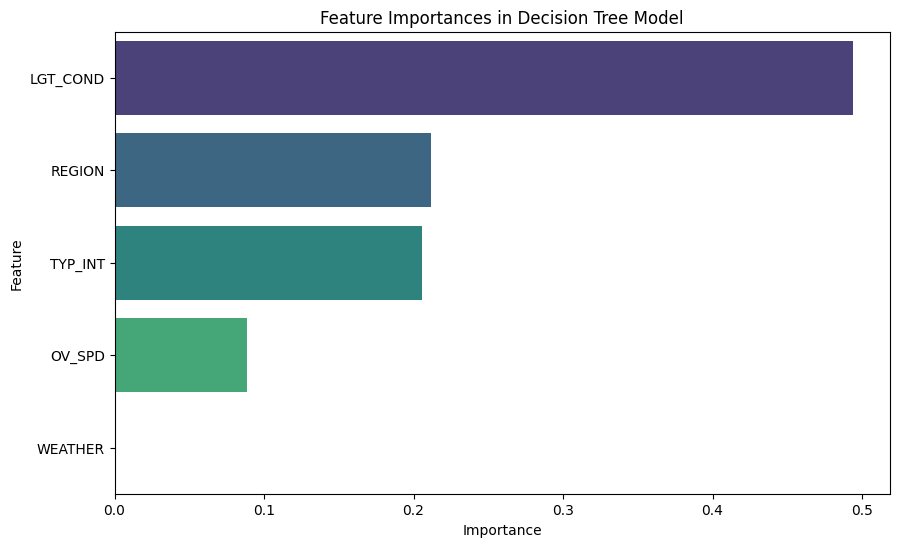

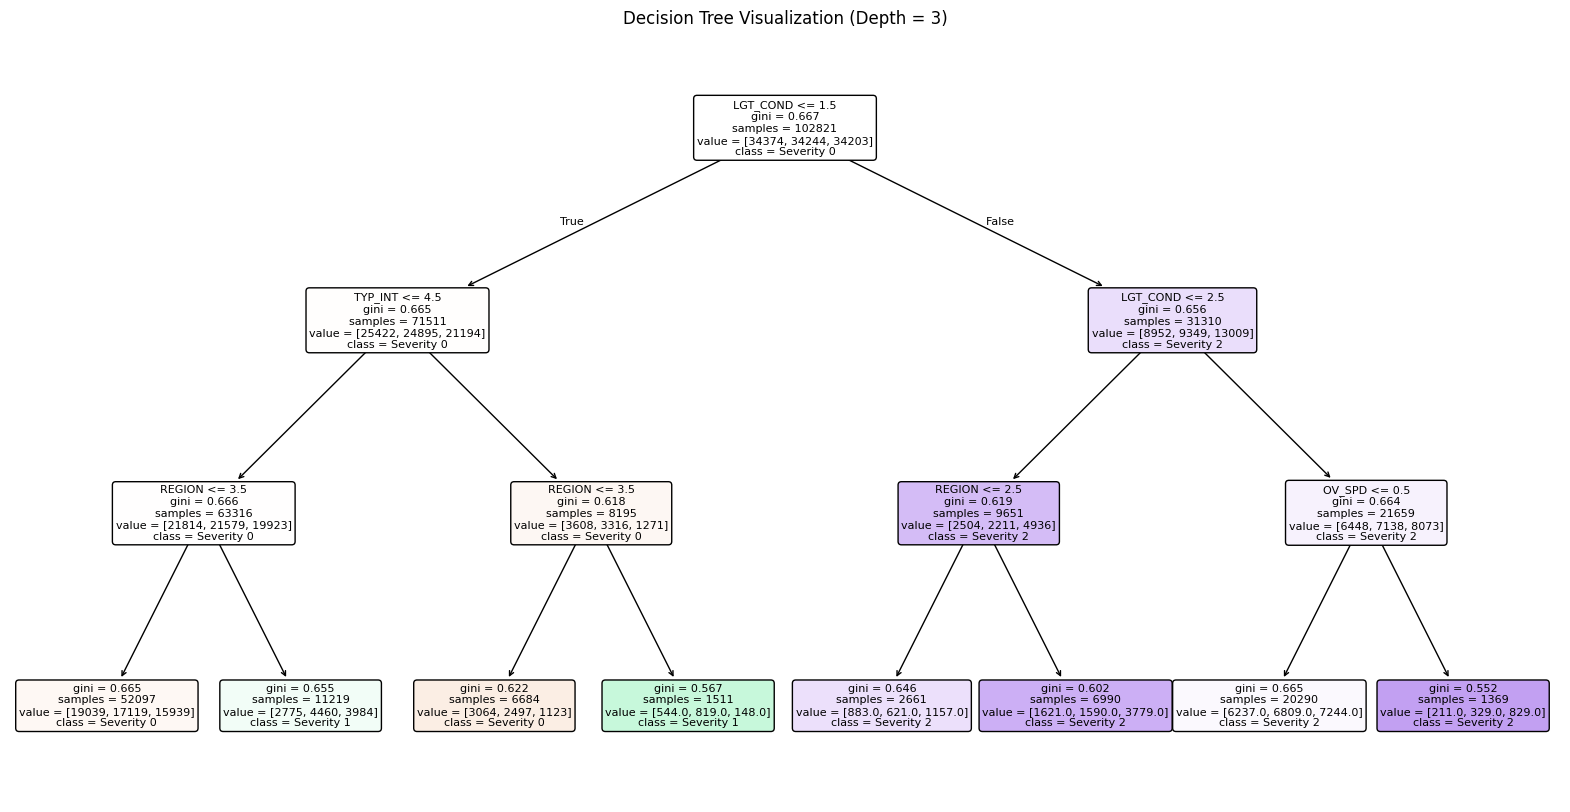


Feature Importances:
    Feature  Importance
1  LGT_COND    0.493722
3    REGION    0.211720
2   TYP_INT    0.205867
4    OV_SPD    0.088691
0   WEATHER    0.000000

Conclusion: There is evidence to reject the null hypothesis (H0).
Environmental factors significantly impact accident severity.


In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, f1_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# Step 2: Load the dataset
df = df_filtered2  # Assuming df_filtered2 is pre-loaded with necessary data

# Step 3: Separate the classes based on MAX_SEV values
df_class_0 = df[df['MAX_SEV'] == 0]
df_class_1 = df[df['MAX_SEV'] == 1]
df_class_2 = df[df['MAX_SEV'] == 2]

# Step 4: Find the maximum sample size for oversampling
max_size = max(len(df_class_0), len(df_class_1), len(df_class_2))

# Oversampling: Up-sample minority classes to match the maximum class size
df_class_0_over = resample(df_class_0, replace=True, n_samples=max_size, random_state=42)
df_class_1_over = resample(df_class_1, replace=True, n_samples=max_size, random_state=42)
df_class_2_over = resample(df_class_2, replace=True, n_samples=max_size, random_state=42)

# Concatenate over-sampled DataFrames to create a balanced dataset
df_balanced = pd.concat([df_class_0_over, df_class_1_over, df_class_2_over])

# Step 5: Select features for the hypothesis
features = ['WEATHER', 'LGT_COND', 'TYP_INT', 'REGION', 'OV_SPD']
target = 'MAX_SEV'

# Step 6: Prepare the data for training
X = df_balanced[features]
y = df_balanced[target]

# Step 7: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Step 8: Train the Decision Tree model with limited depth
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)  # Limit depth to 3 for simpler visualization
dt_model.fit(X_train, y_train)

# Step 9: Make predictions
y_pred = dt_model.predict(X_test)

# Step 10: Evaluate the model using accuracy, precision, recall, F1 score, and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Weighted to handle multiple classes
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision * 100:.2f}%")
print(f"F1 Score (Weighted): {f1 * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 11: Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 12: Feature importance analysis
feature_importances = dt_model.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances in Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 13: Visualize the Decision Tree using plot_tree()
plt.figure(figsize=(20, 10))  # Set the figure size large enough to accommodate the entire tree
plot_tree(dt_model, feature_names=features, class_names=['Severity 0', 'Severity 1', 'Severity 2'], filled=True, rounded=True)
plt.title('Decision Tree Visualization (Depth = 3)')
plt.savefig('decision_tree_visualization_depth_3.png', dpi=300, bbox_inches='tight')  # Save the visualization as a PNG file
plt.show()

# Step 14: Graphviz Visualization (optional)
# Export the decision tree to a dot file and visualize using Graphviz
dot_data = export_graphviz(dt_model, out_file=None,
                           feature_names=features,
                           class_names=['Severity 0', 'Severity 1', 'Severity 2'],
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("decision_tree_visualization_depth_3")  # Saves as a PDF
graph.view()  # View the PDF output

# Step 15: Interpretation of Results
# Based on the accuracy, precision, and F1 score, determine if environmental factors significantly impact accident severity
print("\nFeature Importances:")
print(importance_df)

if importance_df['Importance'].iloc[0] > 0.1:  # Assuming a threshold of 0.1 as significant importance
    print("\nConclusion: There is evidence to reject the null hypothesis (H0).")
    print("Environmental factors significantly impact accident severity.")
else:
    print("\nConclusion: We fail to reject the null hypothesis (H0).")
    print("Environmental factors may not significantly impact accident severity.")


## Random Forest

Accuracy: 51.59%
Precision (Weighted): 52.65%
F1 Score (Weighted): 52.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.56      0.59     22849
           1       0.49      0.49      0.49     17654
           2       0.31      0.41      0.35      5453

    accuracy                           0.52     45956
   macro avg       0.47      0.49      0.48     45956
weighted avg       0.53      0.52      0.52     45956



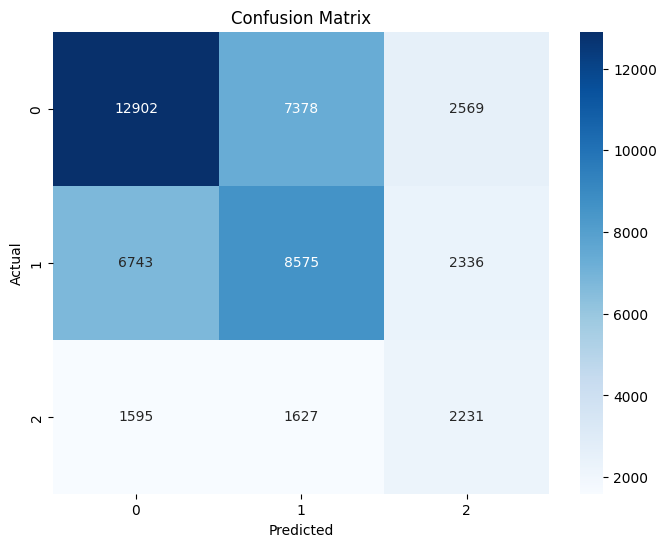

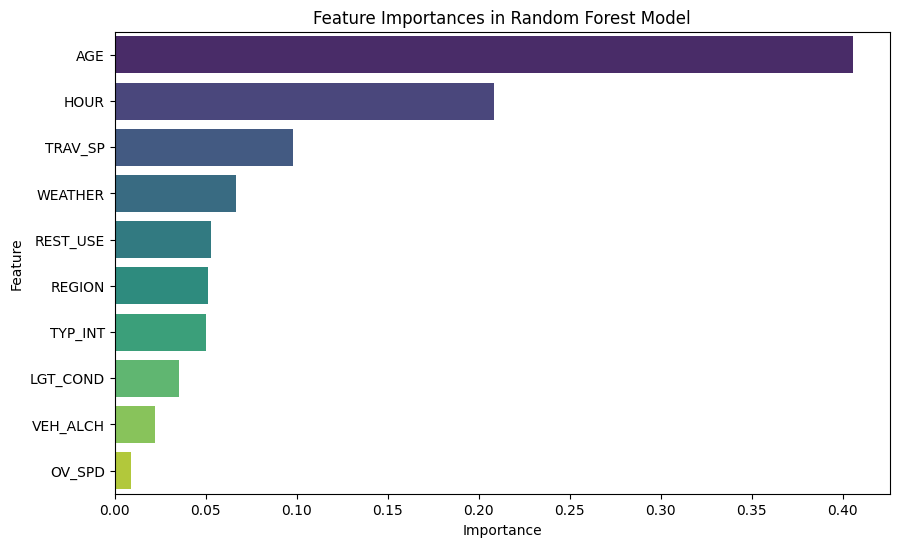


Feature Importances:
    Feature  Importance
3       AGE    0.405509
9      HOUR    0.208420
2   TRAV_SP    0.098247
4   WEATHER    0.066463
0  REST_USE    0.053114
7    REGION    0.051611
6   TYP_INT    0.050016
5  LGT_COND    0.035363
8  VEH_ALCH    0.022423
1    OV_SPD    0.008834

Conclusion: We fail to reject the null hypothesis (H0).
Driver factors significantly impact accident severity.


In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_filtered2 is already pre-loaded with necessary data
df = df_filtered2

# Step 3: Select features for the hypothesis (without duplicates and in correct order)
features = ['REST_USE', 'OV_SPD', 'TRAV_SP', 'AGE', 'WEATHER', 'LGT_COND', 'TYP_INT', 'REGION',"VEH_ALCH","HOUR"]
target = 'MAX_SEV'

# Step 4: Prepare the data for training
X = df[features]
y = df[target]

# Step 5: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# Step 6: Combine X_train and y_train into a single DataFrame for resampling
train_data = X_train.copy()
train_data[target] = y_train

# Step 7: Separate the classes in the training set based on MAX_SEV values
df_class_0 = train_data[train_data[target] == 0]
df_class_1 = train_data[train_data[target] == 1]
df_class_2 = train_data[train_data[target] == 2]

# Step 8: Find the maximum sample size for oversampling
max_size = max(len(df_class_0), len(df_class_1), len(df_class_2))

# Step 9: Over-sampling: Up-sample minority classes to match the maximum class size in the training set
df_class_0_over = resample(df_class_0, replace=True, n_samples=max_size, random_state=42)
df_class_1_over = resample(df_class_1, replace=True, n_samples=max_size, random_state=42)
df_class_2_over = resample(df_class_2, replace=True, n_samples=max_size, random_state=42)

# Concatenate over-sampled DataFrames to create a balanced training dataset
df_oversampled = pd.concat([df_class_0_over, df_class_1_over, df_class_2_over])

# Step 10: Prepare the data for training after oversampling
X_train_oversampled = df_oversampled[features]
y_train_oversampled = df_oversampled[target]

# Step 11: Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_oversampled, y_train_oversampled)

# Step 12: Make predictions on the test data (unbalanced)
y_pred = rf_model.predict(X_test)

# Step 13: Evaluate the model using accuracy, precision, recall, F1 score, and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Weighted to handle multiple classes
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision (Weighted): {precision * 100:.2f}%")
print(f"F1 Score (Weighted): {f1 * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 14: Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 15: Feature importance analysis
feature_importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importances in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 16: Interpretation of Results
print("\nFeature Importances:")
print(importance_df)

Driver_factors = ['AGE', 'TRAV_SP', 'OV_SPD']
significant_features_under = importance_df_under[importance_df_under['Feature'].isin(Driver_factors) & (importance_df_under['Importance'] > 0.1)]

if significant_features_under.empty:
    print("\nConclusion: There is evidence to reject the null hypothesis (H0).")
    print("Driver factors may not significantly impact accident severity.")
else:
    print("\nConclusion: We fail to reject the null hypothesis (H0).")
    print("Driver factors significantly impact accident severity.")


#####UNderSampling RandomForest


--- Evaluation Metrics for Undersampled Model ---
Accuracy: 45.43%
Precision (Weighted): 50.57%
F1 Score (Weighted): 46.70%

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.46      0.52     22849
           1       0.46      0.41      0.43     17654
           2       0.24      0.57      0.34      5453

    accuracy                           0.45     45956
   macro avg       0.44      0.48      0.43     45956
weighted avg       0.51      0.45      0.47     45956



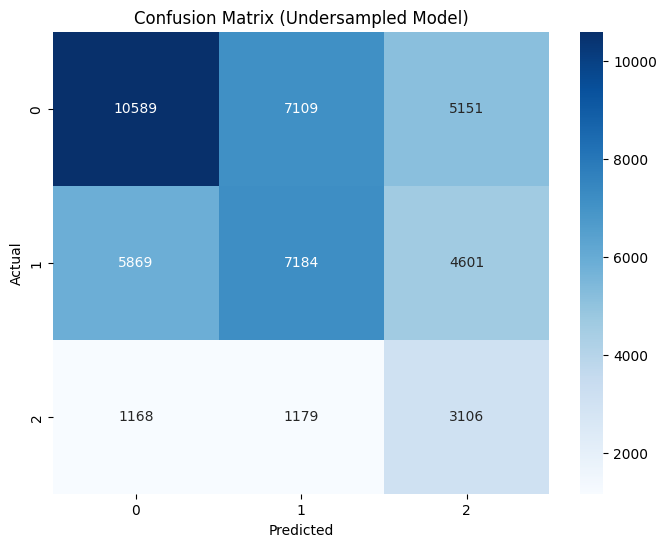

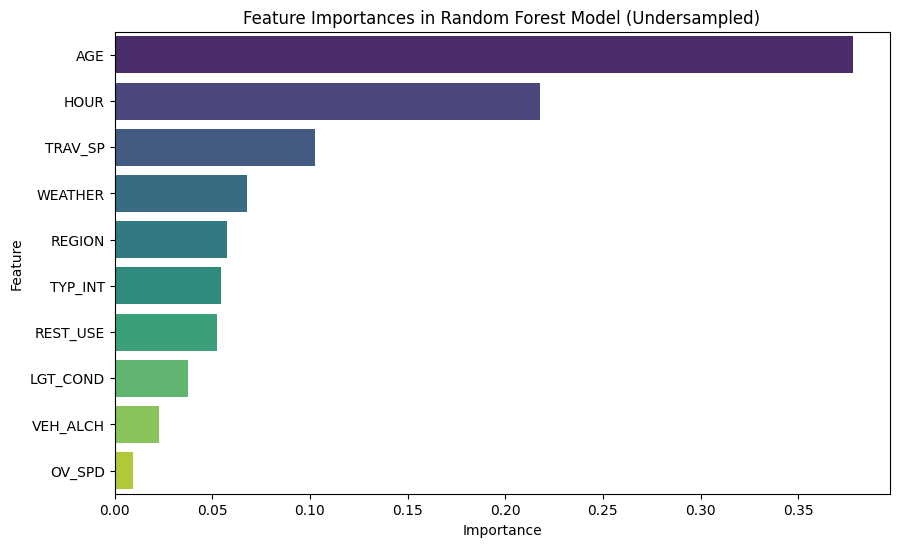


Feature Importances (Undersampled):
    Feature  Importance
3       AGE    0.377841
9      HOUR    0.217803
2   TRAV_SP    0.102458
4   WEATHER    0.067891
7    REGION    0.057504
6   TYP_INT    0.054636
0  REST_USE    0.052353
5  LGT_COND    0.037395
8  VEH_ALCH    0.022865
1    OV_SPD    0.009254

Conclusion: We fail to reject the null hypothesis (H0).
Driver factors significantly impact accident severity.


In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_filtered2 is already pre-loaded with necessary data
df = df_filtered2

# Step 3: Select features for the hypothesis (without duplicates and in correct order)
features = ['REST_USE', 'OV_SPD', 'TRAV_SP', 'AGE', 'WEATHER', 'LGT_COND', 'TYP_INT', 'REGION',"VEH_ALCH","HOUR"]
target = 'MAX_SEV'

categorical_columns = ['WEATHER', 'REST_USE', 'OV_SPD', 'LGT_COND', 'TYP_INT', 'REGION', 'VEH_ALCH']


# Step 4: Prepare the data for training
X = df[features]
#X = pd.get_dummies(X, columns=categorical_columns)
y = df[target]

# Step 5: Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)


# Step 6: Combine X_train and y_train into a single DataFrame for resampling
train_data = X_train.copy()
train_data[target] = y_train

# Step 7: Separate the classes in the training set based on MAX_SEV values
df_class_0 = train_data[train_data[target] == 0]
df_class_1 = train_data[train_data[target] == 1]
df_class_2 = train_data[train_data[target] == 2]

# Step 8: Find the minimum sample size for undersampling
min_size = min(len(df_class_0), len(df_class_1), len(df_class_2))

# Step 9: Under-sampling: Down-sample majority classes to match the minimum class size in the training set
df_class_0_under = resample(df_class_0, replace=False, n_samples=min_size, random_state=42)
df_class_1_under = resample(df_class_1, replace=False, n_samples=min_size, random_state=42)
df_class_2_under = resample(df_class_2, replace=False, n_samples=min_size, random_state=42)

# Concatenate under-sampled DataFrames to create a balanced training dataset
df_undersampled = pd.concat([df_class_0_under, df_class_1_under, df_class_2_under])



# Step 10: Prepare the data for training after undersampling
#X_train_undersampled = df_undersampled.drop(columns=[target])
X_train_undersampled = df_undersampled[features]
y_train_undersampled = df_undersampled[target]

# Step 11: Train the Random Forest model using undersampled data
rf_model_under = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_under.fit(X_train_undersampled, y_train_undersampled)

# Step 12: Make predictions on the test data (unbalanced)
y_pred_under = rf_model_under.predict(X_test)

# Step 13: Evaluate the model using accuracy, precision, recall, F1 score, and confusion matrix
accuracy_under = accuracy_score(y_test, y_pred_under)
precision_under = precision_score(y_test, y_pred_under, average='weighted')
f1_under = f1_score(y_test, y_pred_under, average='weighted')
conf_matrix_under = confusion_matrix(y_test, y_pred_under)

# Print the evaluation metrics for undersampled model
print("\n--- Evaluation Metrics for Undersampled Model ---")
print(f"Accuracy: {accuracy_under * 100:.2f}%")
print(f"Precision (Weighted): {precision_under * 100:.2f}%")
print(f"F1 Score (Weighted): {f1_under * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_under))

# Step 14: Visualize the Confusion Matrix for undersampled model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_under, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix (Undersampled Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 15: Feature importance analysis for the undersampled model
feature_importances_under = rf_model_under.feature_importances_

# Create a DataFrame for feature importances
#importance_df_under = pd.DataFrame({'Feature': features, 'Importance': feature_importances_under}).sort_values(by='Importance', ascending=False)
importance_df_under = pd.DataFrame({
    'Feature': X_train_undersampled.columns,  # Use the columns from X_train_undersampled
    'Importance': feature_importances_under
}).sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_under, palette='viridis')
plt.title('Feature Importances in Random Forest Model (Undersampled)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 16: Interpretation of Results for undersampled model
print("\nFeature Importances (Undersampled):")
print(importance_df_under)

# Hypothesis testing based on environmental factors
Driver_factors = ['AGE', 'TRAV_SP', 'OV_SPD']
significant_features_under = importance_df_under[importance_df_under['Feature'].isin(Driver_factors) & (importance_df_under['Importance'] > 0.1)]

if significant_features_under.empty:
    print("\nConclusion: There is evidence to reject the null hypothesis (H0).")
    print("Driver factors may not significantly impact accident severity.")
else:
    print("\nConclusion: We fail to reject the null hypothesis (H0).")
    print("Driver factors significantly impact accident severity.")


####UnderSampling Random Forest encoding



--- Evaluation Metrics for Undersampled Model ---
Accuracy: 45.72%
Precision (Weighted): 50.80%
F1 Score (Weighted): 46.98%

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.46      0.52     22849
           1       0.47      0.41      0.44     17654
           2       0.24      0.57      0.34      5453

    accuracy                           0.46     45956
   macro avg       0.44      0.48      0.44     45956
weighted avg       0.51      0.46      0.47     45956



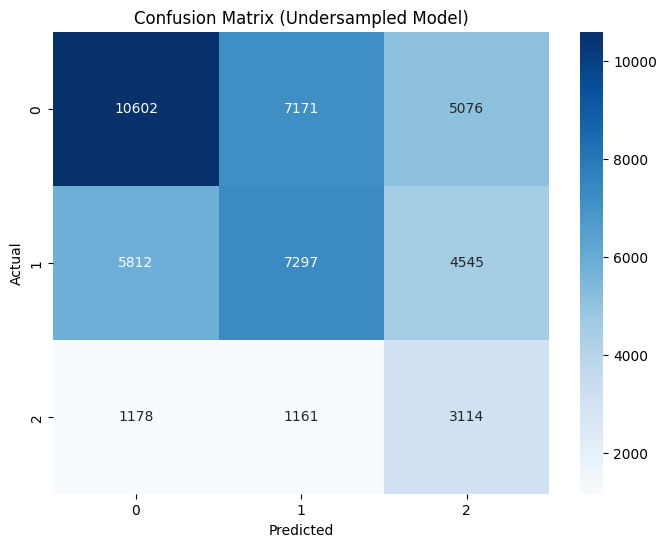

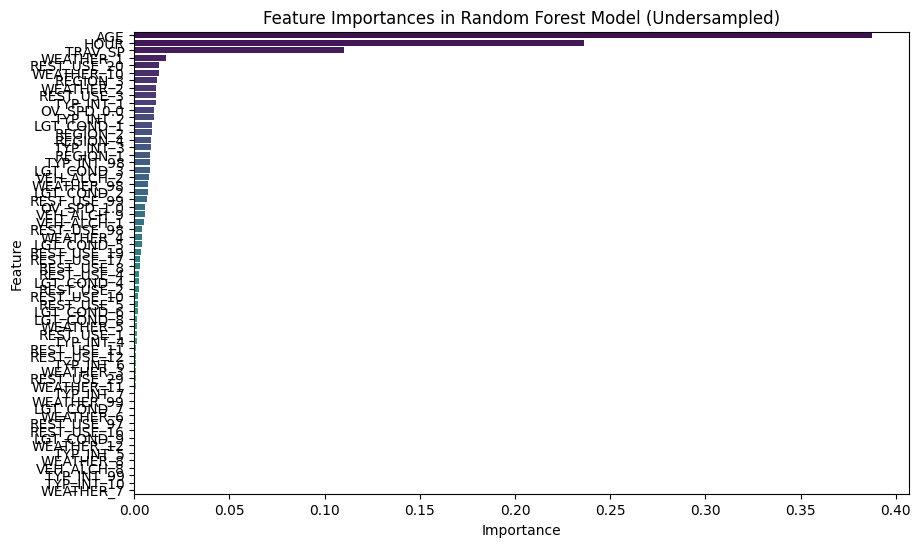


Feature Importances (Undersampled):
        Feature  Importance
1           AGE    0.387669
2          HOUR    0.236182
0       TRAV_SP    0.110308
3     WEATHER_1    0.016772
28  REST_USE_20    0.013191
..          ...         ...
10    WEATHER_8    0.000201
60   VEH_ALCH_8    0.000184
53   TYP_INT_99    0.000183
51   TYP_INT_10    0.000123
9     WEATHER_7    0.000058

[62 rows x 2 columns]

Conclusion: There is evidence to reject the null hypothesis (H0).
Environmental factors may not significantly impact accident severity.


In [ ]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_filtered2 is already pre-loaded with necessary data
df = df_filtered2

# Step 3: Select features for the hypothesis (without duplicates and in correct order)
features = ['REST_USE', 'OV_SPD', 'TRAV_SP', 'AGE', 'WEATHER', 'LGT_COND', 'TYP_INT', 'REGION',"VEH_ALCH","HOUR"]
target = 'MAX_SEV'

categorical_columns = ['WEATHER', 'REST_USE', 'OV_SPD', 'LGT_COND', 'TYP_INT', 'REGION', 'VEH_ALCH']


# Step 4: Prepare the data for training
X = df[features]
X = pd.get_dummies(X, columns=categorical_columns)
y = df[target]

# Step 5: Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)


# Step 6: Combine X_train and y_train into a single DataFrame for resampling
train_data = X_train.copy()
train_data[target] = y_train

# Step 7: Separate the classes in the training set based on MAX_SEV values
df_class_0 = train_data[train_data[target] == 0]
df_class_1 = train_data[train_data[target] == 1]
df_class_2 = train_data[train_data[target] == 2]

# Step 8: Find the minimum sample size for undersampling
min_size = min(len(df_class_0), len(df_class_1), len(df_class_2))

# Step 9: Under-sampling: Down-sample majority classes to match the minimum class size in the training set
df_class_0_under = resample(df_class_0, replace=False, n_samples=min_size, random_state=42)
df_class_1_under = resample(df_class_1, replace=False, n_samples=min_size, random_state=42)
df_class_2_under = resample(df_class_2, replace=False, n_samples=min_size, random_state=42)

# Concatenate under-sampled DataFrames to create a balanced training dataset
df_undersampled = pd.concat([df_class_0_under, df_class_1_under, df_class_2_under])



# Step 10: Prepare the data for training after undersampling
X_train_undersampled = df_undersampled.drop(columns=[target])
#X_train_undersampled = df_undersampled[features]
y_train_undersampled = df_undersampled[target]

# Step 11: Train the Random Forest model using undersampled data
rf_model_under = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_under.fit(X_train_undersampled, y_train_undersampled)

# Step 12: Make predictions on the test data (unbalanced)
y_pred_under = rf_model_under.predict(X_test)

# Step 13: Evaluate the model using accuracy, precision, recall, F1 score, and confusion matrix
accuracy_under = accuracy_score(y_test, y_pred_under)
precision_under = precision_score(y_test, y_pred_under, average='weighted')
f1_under = f1_score(y_test, y_pred_under, average='weighted')
conf_matrix_under = confusion_matrix(y_test, y_pred_under)

# Print the evaluation metrics for undersampled model
print("\n--- Evaluation Metrics for Undersampled Model ---")
print(f"Accuracy: {accuracy_under * 100:.2f}%")
print(f"Precision (Weighted): {precision_under * 100:.2f}%")
print(f"F1 Score (Weighted): {f1_under * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_under))

# Step 14: Visualize the Confusion Matrix for undersampled model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_under, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix (Undersampled Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 15: Feature importance analysis for the undersampled model
feature_importances_under = rf_model_under.feature_importances_

# Create a DataFrame for feature importances
#importance_df_under = pd.DataFrame({'Feature': features, 'Importance': feature_importances_under}).sort_values(by='Importance', ascending=False)
importance_df_under = pd.DataFrame({
    'Feature': X_train_undersampled.columns,  # Use the columns from X_train_undersampled
    'Importance': feature_importances_under
}).sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df_under, palette='viridis')
plt.title('Feature Importances in Random Forest Model (Undersampled)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Step 16: Interpretation of Results for undersampled model
print("\nFeature Importances (Undersampled):")
print(importance_df_under)

# Hypothesis testing based on environmental factors
environmental_factors = ['WEATHER', 'LGT_COND', 'VSURCOND', 'TYP_INT']
significant_features_under = importance_df_under[importance_df_under['Feature'].isin(environmental_factors) & (importance_df_under['Importance'] > 0.1)]

if significant_features_under.empty:
    print("\nConclusion: There is evidence to reject the null hypothesis (H0).")
    print("Environmental factors may not significantly impact accident severity.")
else:
    print("\nConclusion: We fail to reject the null hypothesis (H0).")
    print("Environmental factors significantly impact accident severity.")
